# Exercise 4: XGBoost Trees
## Detection of patterns

#### Amjadi Bahador - 2040470
#### Attar Aidin - 2048654
#### Joulaei Vijouyeh Roya - 2050954
#### Roshana Mojtaba - 2050955

# -----------------------------------
### Part 1a: Comparison between CNN and XGBoost model
# -----------------------------------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
%run plot.py

### Read data

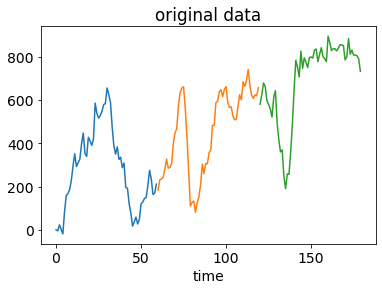

data:  20


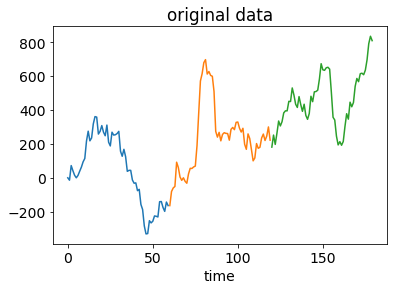

data:  50


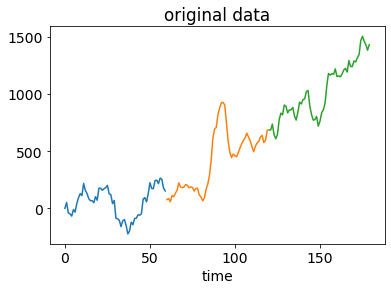

data:  100


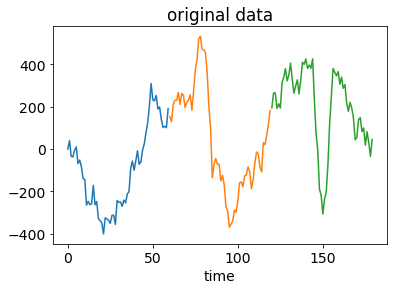

data:  150


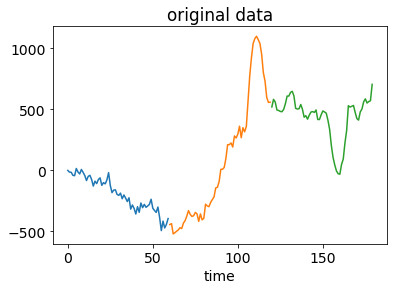

data:  200


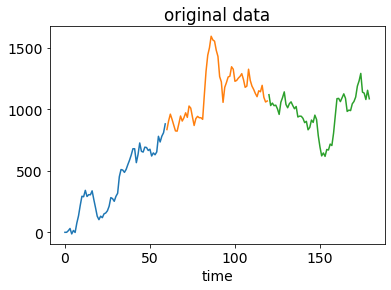

data:  250


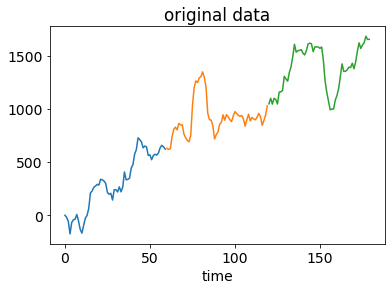

data:  300


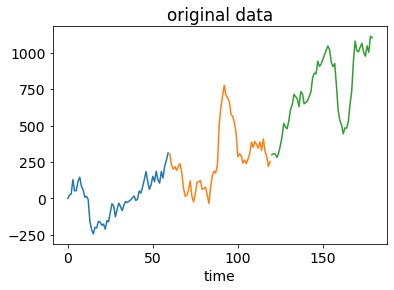

data:  400


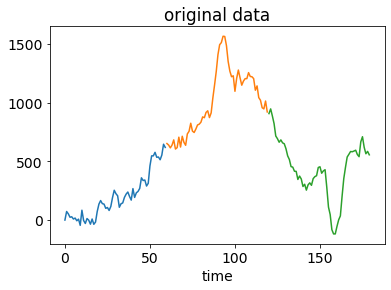

data:  500


In [3]:
dim = [20, 50, 100, 150, 200, 250, 300, 400, 500]
x = [np.zeros(shape=(i, 60)) for i in dim]
y = [np.zeros(shape=(i    )) for i in dim]

for i, n in enumerate(dim):
    str0 = f'ts_L60_Z12_A500_DX50_bias5_N{n}.dat'
    fnamex='DATA/x_'+str0
    fnamey='DATA/y_'+str0
    x[i] = np.loadtxt(fnamex, delimiter=" ",dtype=float)
    N,L = len(x[i]), len(x[i][0])

    Show_data(x[i],L,"original data")

    # note: here it does not need to be converted to the 3-bit version, a label remains y[i]=0,1,2
    y[i] = np.loadtxt(fnamey, dtype=int)
    n_class = 3    #  = len(np.unique(y))
    print('data: ',N)

In [4]:
def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t)
    #build time columns
    time_col = np.tile(np.arange(t),N)
    #build var columns
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

## TSFRESH: extract features

Input data format: DATAFRAME

first column $\to$ id of the sample 

second column $\to$  id of the time step

third column $\to$ value of the feature of _id_-sample at _id_-step

For more: https://tsfresh.readthedocs.io/en/latest/text/data_formats.html

In [5]:
#get df
df = [get_df(x[i]) for i in range(len(dim))] 

#check that last columns, if reshaped is equal to x
#df_to_array = df.values[:,-1].reshape(x.shape[0],x.shape[1])
#sum of different values: should be 0
#print('Differences:',np.sum(df_to_array != x))

df[0]

id  time   value
0      0     0     0.0
1      0     1    -5.0
2      0     2    23.0
3      0     3     3.0
4      0     4   -19.0
...   ..   ...     ...
1195  19    55  4754.0
1196  19    56  4734.0
1197  19    57  4722.0
1198  19    58  4772.0
1199  19    59  4746.0

[1200 rows x 3 columns]

In [6]:
#extract features
x_features = [extract_features(df[i], #our dataframe
                               column_id='id', #sample id, from 0 to N
                               column_sort='time', #timestep, from 0 to t
                               column_kind=None, #we have only one feature
                               column_value='value', #value of input 
                               n_jobs=4) #number of cores
              for i in range(len(dim))]

Feature Extraction: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


In [7]:
x_features_data = pd.DataFrame(x_features)
x_features_data.to_csv('results_DATA/x_features.csv')

In [8]:
#remove columns with NaN or inf
for i in range(len(dim)):
    x_features[i].replace([np.inf, -np.inf], np.nan)
    x_features[i] = x_features[i].dropna(axis='columns')

### Split train/val

In [9]:
#split data into training and validation

perc_train=0.8
N_train=[int(perc_train*len(x[i]))  for i in range(len(dim))]
x_train=[x_features[i][:N_train[i]] for i in range(len(dim))]
y_train=[y[i][:N_train[i]]          for i in range(len(dim))]
x_val  =[x_features[i][N_train[i]:] for i in range(len(dim))]
y_val  =[y[i][N_train[i]:]          for i in range(len(dim))]
N_val  =[len(x_val[i])              for i in range(len(dim))]

for i in range(len(dim)):
    print(i, 'N_train=',N_train[i],'  N_val=',N_val[i],'  n_class=',n_class)

0 N_train= 16   N_val= 4   n_class= 3
1 N_train= 40   N_val= 10   n_class= 3
2 N_train= 80   N_val= 20   n_class= 3
3 N_train= 120   N_val= 30   n_class= 3
4 N_train= 160   N_val= 40   n_class= 3
5 N_train= 200   N_val= 50   n_class= 3
6 N_train= 240   N_val= 60   n_class= 3
7 N_train= 320   N_val= 80   n_class= 3
8 N_train= 400   N_val= 100   n_class= 3


In [10]:
#look at x_train
x_train[0]

value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
0                                              1.0                       0.0   
1                                              1.0                       0.0   
2                                              1.0                       0.0   
3                                              1.0                       0.0   
4                                              1.0                       0.0   
5                                              1.0                       0.0   
6                                              1.0                       1.0   
7                                              1.0                       0.0   
8                                              1.0                       0.0   
9                                              1.0                       0.0   
10                                             1.0                       0.0   
11                                             1.0                       0.0   
12                                             1.0                       0.0   
13                                             1.0                       0.0   
14                                             1.0                       0.0   
15                                             1.0                       0.0   

    value__has_duplicate_min  value__has_duplicate  value__sum_values  \
0                        0.0                   1.0            16750.0   
1                        0.0                   1.0            27302.0   
2                        0.0                   1.0            41650.0   
3                        0.0                   1.0            37428.0   
4                        0.0                   1.0            58260.0   
5                        0.0                   1.0            89485.0   
6                        0.0                   1.0           120965.0   
7                        0.0                   1.0           130625.0   
8                        0.0                   1.0           153223.0   
9                        0.0                   1.0           181771.0   
10                       0.0                   1.0           175775.0   
11                       0.0                   1.0           171731.0   
12                       0.0                   1.0           195675.0   
13                       0.0                   1.0           231510.0   
14                       0.0                   1.0           224478.0   
15                       0.0                   1.0           227834.0   

    value__abs_energy  value__mean_abs_change  value__mean_change  \
0           6729150.0               43.101695            3.576271   
1          14556188.0               44.000000            8.033898   
2          30904786.0               45.491525            2.576271   
3          23935100.0               44.372881           -2.169492   
4          60723594.0               54.593220           10.728814   
5         137140845.0               45.644068           10.830508   
6         244298969.0               39.559322            3.152542   
7         287046061.0               53.457627            5.050847   
8         394072457.0               52.220339           11.169492   
9         551550183.0               41.016949           -2.033898   
10        516480085.0               48.915254           -1.762712   
11        492860205.0               46.203390            3.288136   
12        640327083.0               35.694915            8.338983   
13        895581132.0               51.830508            4.983051   
14        842234510.0               51.186441            4.169492   
15        867055934.0               32.593220           -8.627119   

    value__mean_second_derivative_central  value__median  ...  \
0                                0.405172          289.5  ...   
1                               -0.086207          509.5  ...   
2                               

## XGB

In [11]:
#for i in range(len(dim)):
#    print(np.any(np.isinf(x_train[i])))

#0,3,6
for i in range(len(dim)):
    x_train[i].drop(columns=['value__sample_entropy'],inplace=True)
    x_val[i].drop(columns=['value__sample_entropy'],inplace=True)

/tmp/ipykernel_133921/4195152145.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[i].drop(columns=['value__sample_entropy'],inplace=True)
/tmp/ipykernel_133921/4195152145.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val[i].drop(columns=['value__sample_entropy'],inplace=True)
/tmp/ipykernel_133921/4195152145.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[i].drop(columns=['value__sample_entropy'],inplace=

In [12]:
# reproducibility
np.random.seed(12345)

#define parameters for xgboost
params = {'max_depth':6,'min_child_weight':1,\
          'learning_rate':0.3,'use_label_encoder':False}

#build model with given params
model = [XGBClassifier(**params) for i in range(len(dim))]
scaler = StandardScaler()
x_trainScaled = [scaler.fit_transform(x_train[i]) for i in range(len(dim))]

#fit
for i in range(len(dim)):
    model[i].fit(x_train[i].values,y_train[i])

[15:18:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

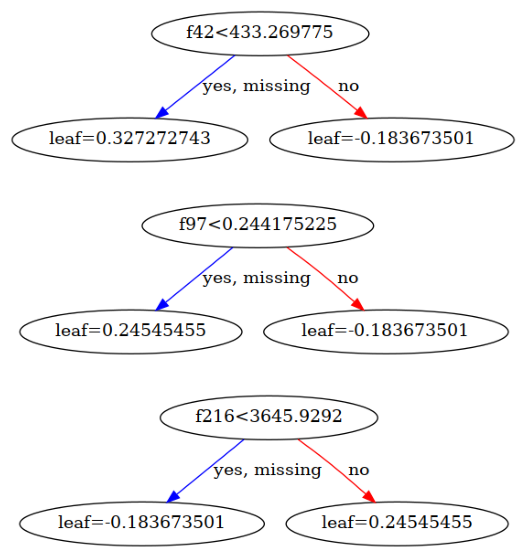

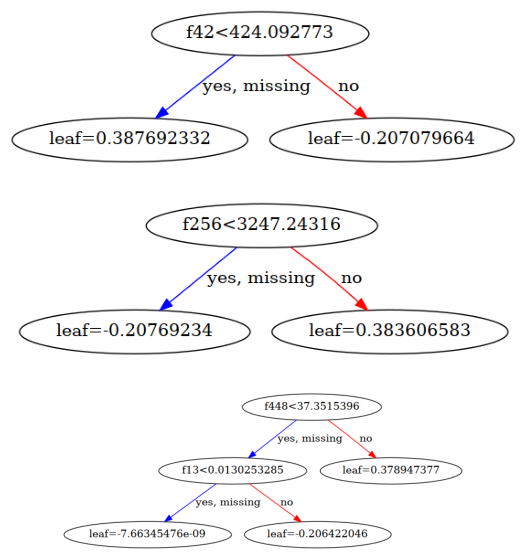

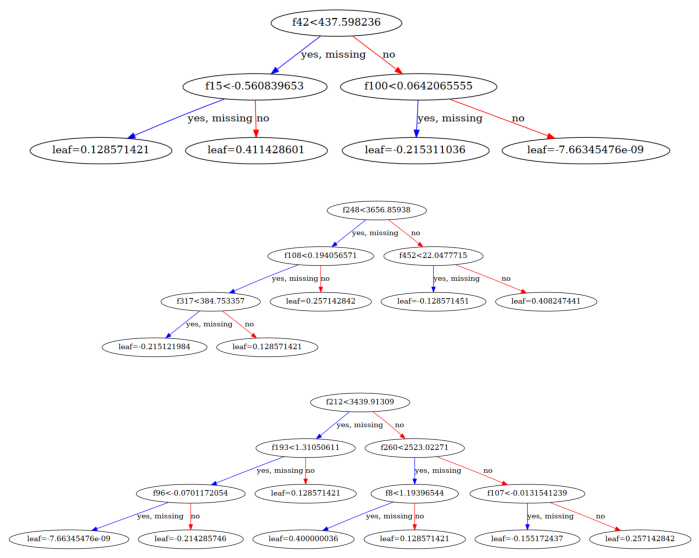

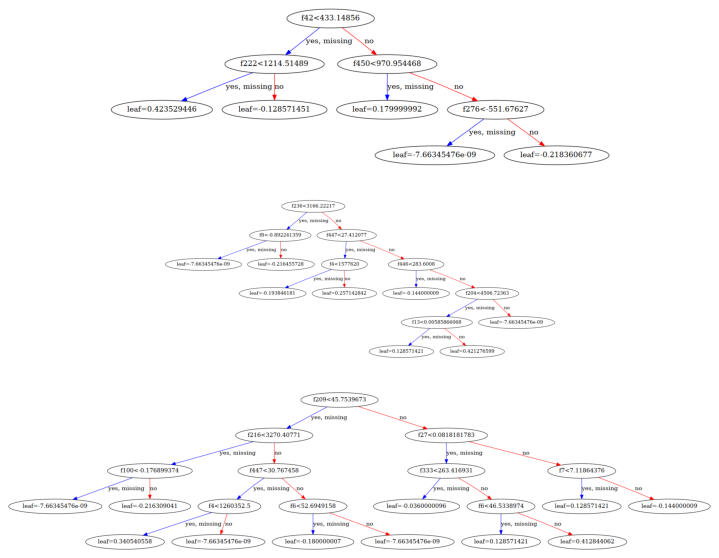

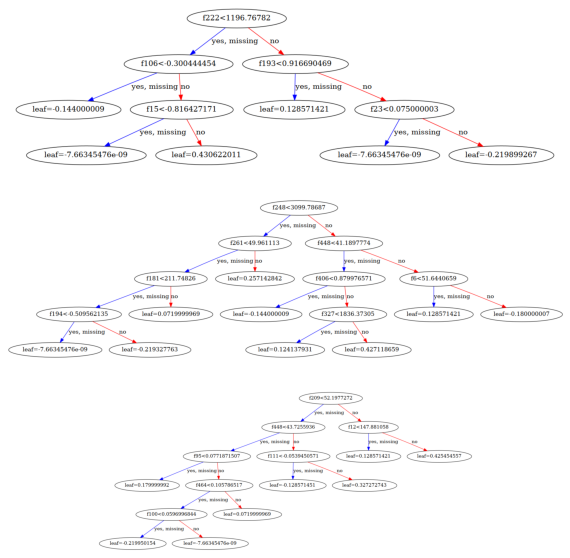

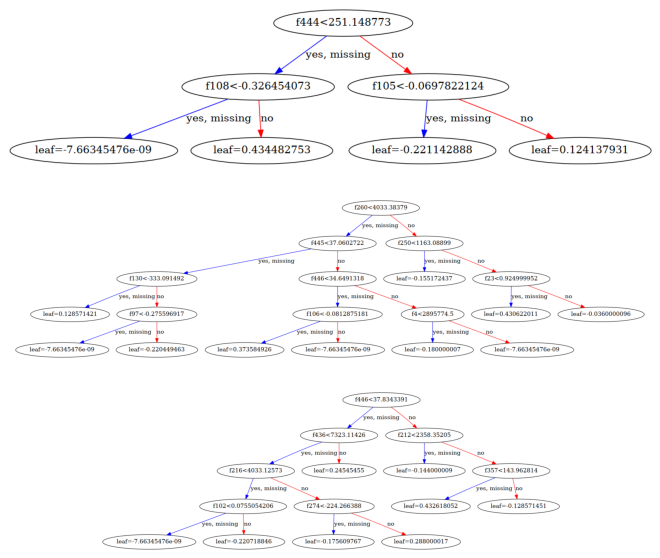

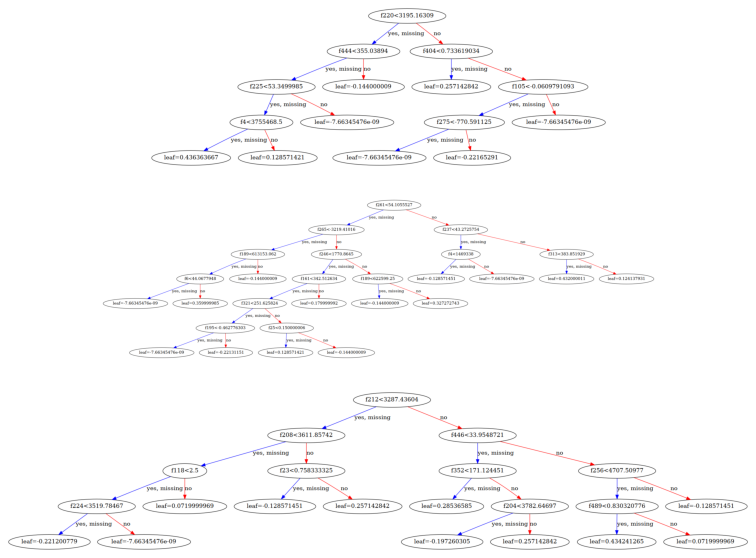

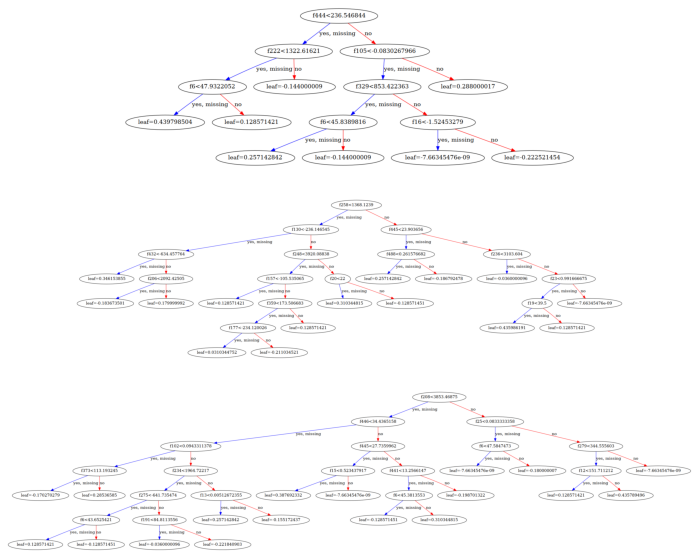

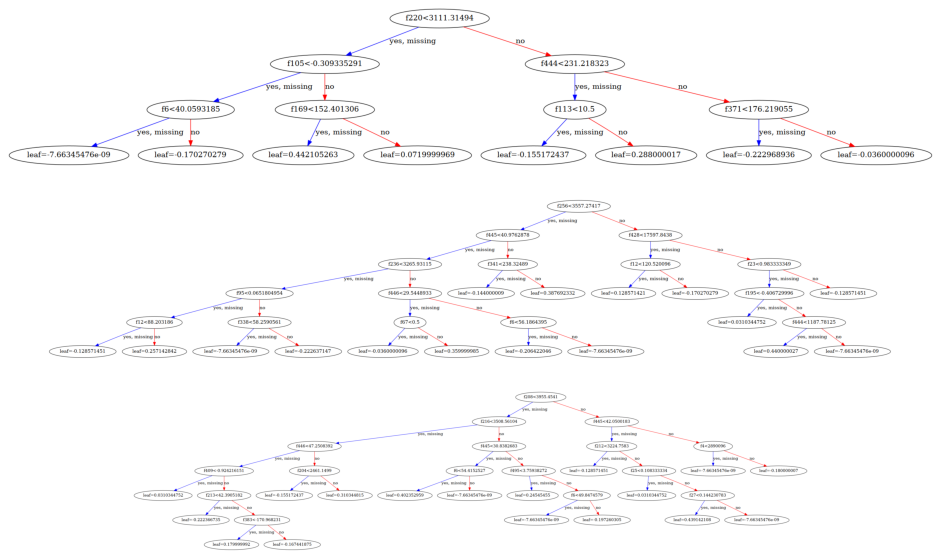

In [13]:
#plot tree


for j in range(len(dim)):
    fig, AX = plt.subplots(3,1,figsize=(30, 10))
    for i in range(3):
        ax=AX[i]
        plot_tree(model[j], num_trees=i, ax=ax)
    
    fig.savefig("DATA/trees-time-ser{j}.png", dpi=300, pad_inches=0.02)

In [14]:
from sklearn.metrics import accuracy_score

#predict labels on training set
y_pred_train = [model[i].predict(x_train[i]) for i in range(len(dim))]
#predict labels on validation set
y_pred_val = [model[i].predict(x_val[i]) for i in range(len(dim))]

y_pred_val_soft = [model[i].predict_proba(x_val[i]) for i in range(len(dim))]



#compute accuracies
acc_train = [accuracy_score(y_train[i],y_pred_train[i]) for i in range(len(dim))]
acc_val   = [accuracy_score(y_val[i],y_pred_val[i]) for i in range(len(dim))]

#print accuracies
for i in range(len(dim)):
    print(i,': Training accuracy:',acc_train[i])
    print(i,': Validation accuracy:',acc_val[i])

0 : Training accuracy: 1.0
0 : Validation accuracy: 0.75
1 : Training accuracy: 1.0
1 : Validation accuracy: 0.5
2 : Training accuracy: 1.0
2 : Validation accuracy: 0.85
3 : Training accuracy: 1.0
3 : Validation accuracy: 0.9666666666666667
4 : Training accuracy: 1.0
4 : Validation accuracy: 0.9
5 : Training accuracy: 1.0
5 : Validation accuracy: 0.9
6 : Training accuracy: 1.0
6 : Validation accuracy: 0.9166666666666666
7 : Training accuracy: 1.0
7 : Validation accuracy: 0.9625
8 : Training accuracy: 1.0
8 : Validation accuracy: 0.92


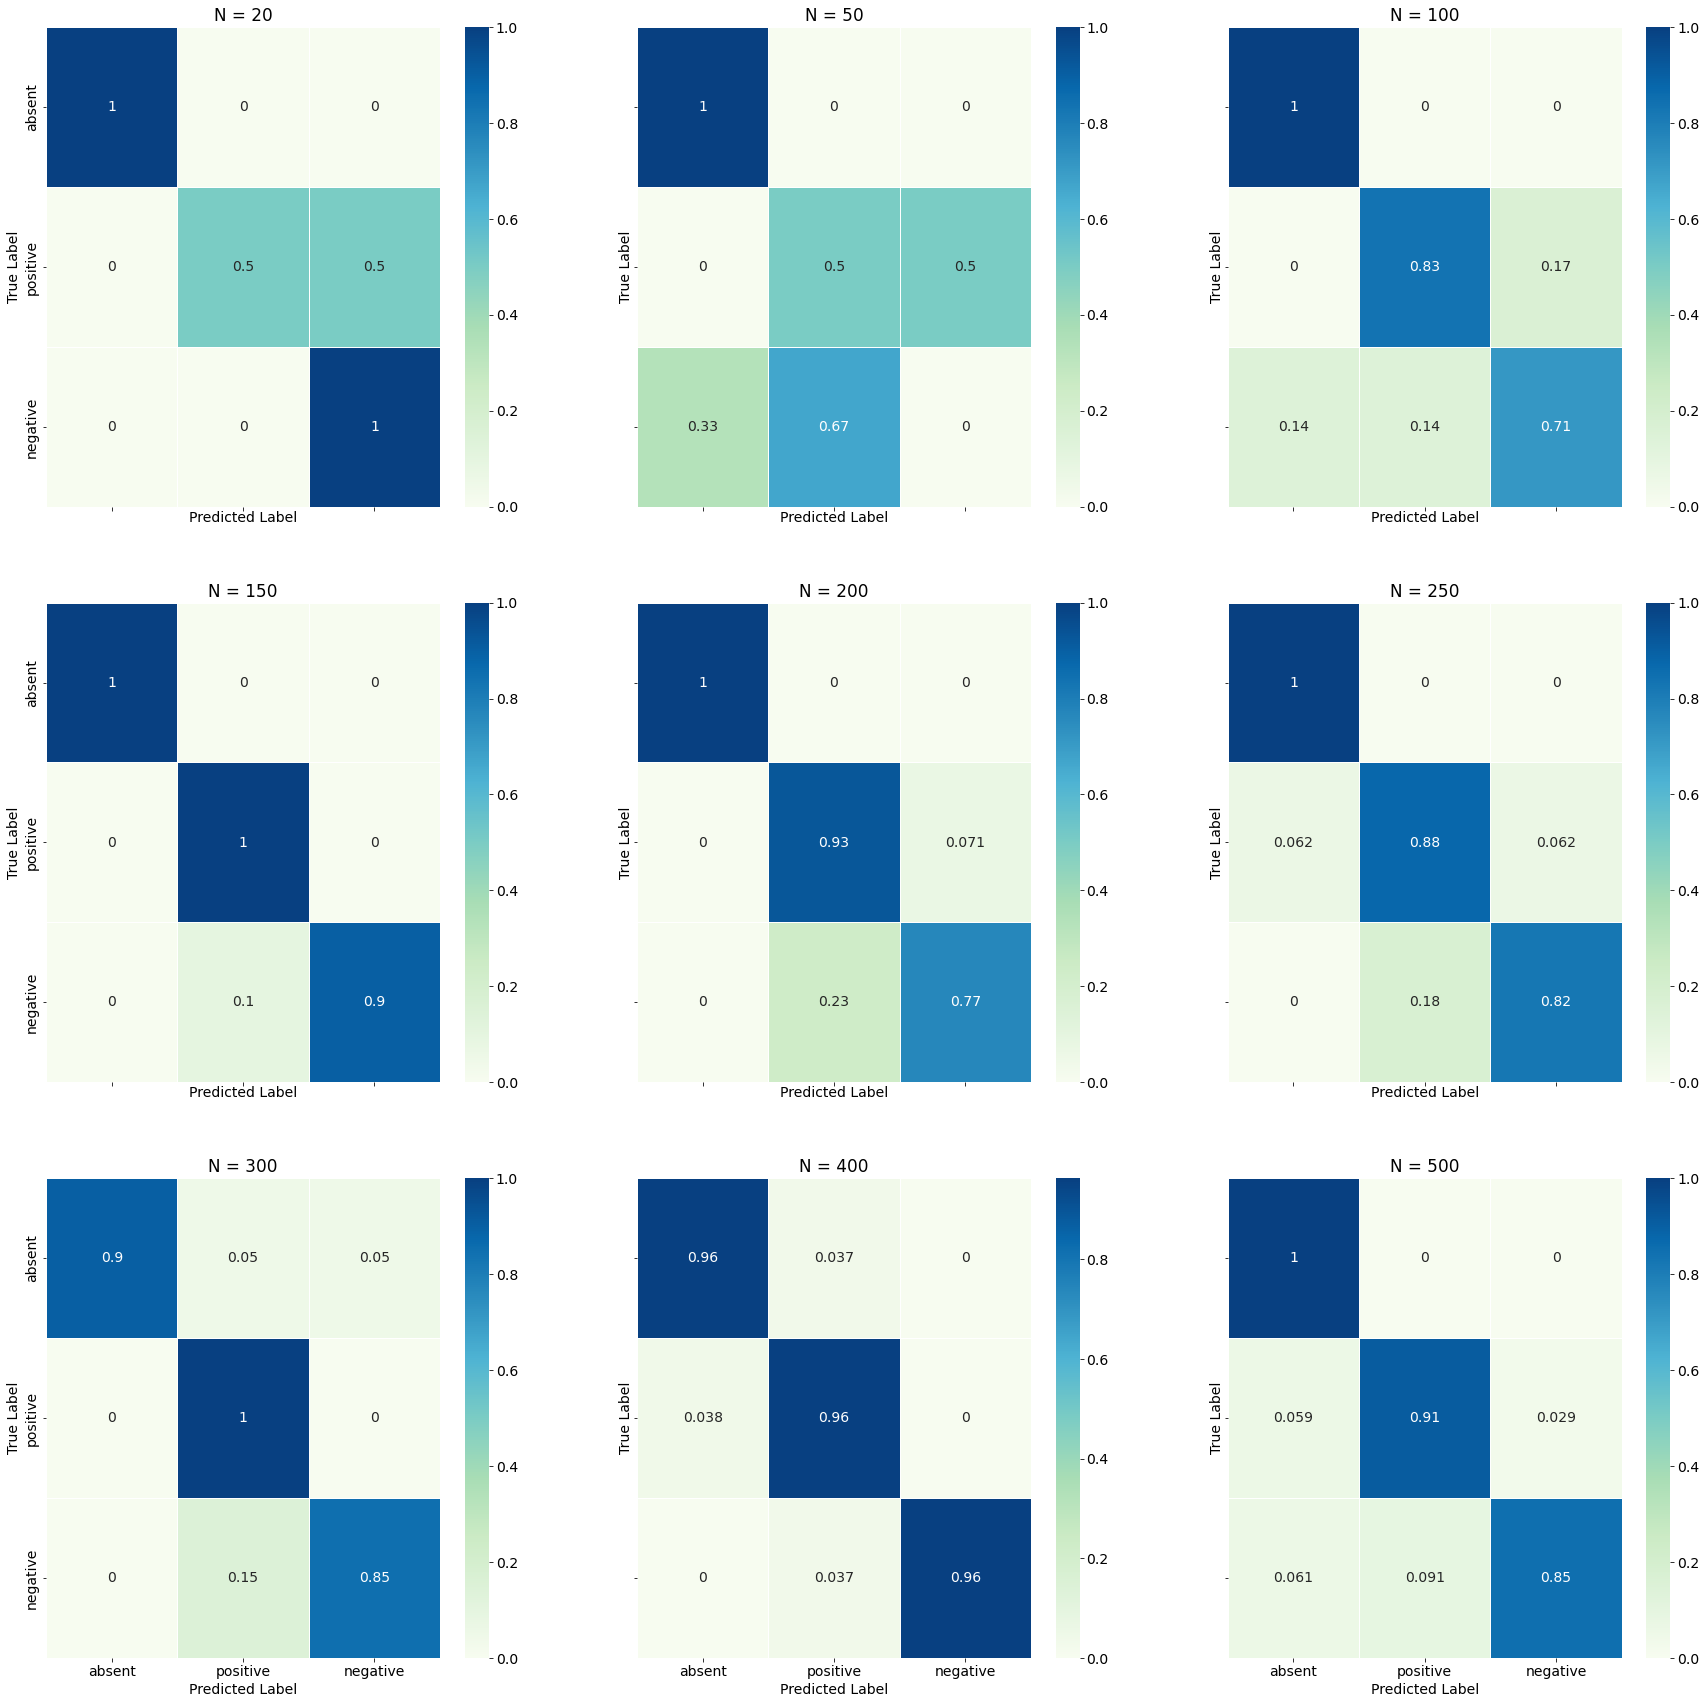

In [15]:
import seaborn as sns
from sklearn import metrics

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(ax, validations, predictions, label="Model"):

    matrix = metrics.confusion_matrix(validations, predictions, normalize='true')
    #plt.figure(figsize=(6, 5))
    sns.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                #fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap,
                ax = ax)
    ax.set_title(label)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

y_pred_val = [model[i].predict(x_val[i]) for i in range(len(dim))]
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30,30), sharex=True, sharey=True)
col = row = 0
for i, N in enumerate(dim):
    show_confusion_matrix(ax[row, col], y_val[i], y_pred_val[i], f'N = {N}')
    col += 1
    if col == 3:
        col = 0
        row += 1
plt.show()

### Defininition of the CNN

In [16]:
from tensorflow.keras.utils import to_categorical

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D
import pandas as pd

from keras import initializers, regularizers
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from scipy import stats
import seaborn 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from keras import initializers, regularizers
import tensorflow.random as tf_r
tf_r.set_seed(12345)

In [17]:
"""Rescaling the Data"""

def reg_scale(x):
    return x/400

def std_scale(x, N):
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]
    return x/np.sqrt(x.var())

def norm_scale(x):
    return (x - np.min(x, axis=0)) / np.abs(np.max(x, axis=0) - np.min(x, axis=0))

def log_scale(x): 
    x = x - np.min(x, axis=0) + 0.0000001 #shifting the data to be greater than 0
    return np.log10(x)

N = [len(x[i])     for i in range(len(dim))]
L = [len(x[i][0]) for i in range(len(dim))]

#x_CNN     =  [reg_scale( x[i]) for i in range(len(dim))]
x_CNN     =  [std_scale( x[i], N[i]) for i in range(len(dim))]
#x_CNN     =  [norm_scale(x[i]) for i in range(len(dim))]
#x_CNN     =  [log_scale( x[i]) for i in range(len(dim))]

perc_train=0.8
N_train_CNN=[int(perc_train*len(x[i]))  for i in range(len(dim))]
x_train_CNN = [x[i][:N_train_CNN[i]] for i in range(len(dim))]
y_train_CNN = [to_categorical(y[i][:N_train_CNN[i]], 3) for i in range(len(dim))]
x_val_CNN = [x[i][N_train_CNN[i]:] for i in range(len(dim))]
y_val_CNN = [to_categorical(y[i][N_train_CNN[i]:],3) for i in range(len(dim))]
N_val_CNN = [len(x_val[i]) for i in range(len(dim))]
for i in range(len(dim)):
    print(i, 'N_train=',N_train_CNN[i],'  N_val=',N_val_CNN[i],'  L=',L[i],'  n_class=',n_class)


# Keras wants an additional dimension with a 1 at the end
for i in range(len(dim)):
    x_train_CNN[i] = x_train_CNN[i].reshape(x_train_CNN[i].shape[0], L[i], 1)
    x_val_CNN[i] =  x_val_CNN[i].reshape(x_val_CNN[i].shape[0], L[i], 1)

input_shape = [(L[i], 1) for i in range(len(dim))]

0 N_train= 16   N_val= 4   L= 60   n_class= 3
1 N_train= 40   N_val= 10   L= 60   n_class= 3
2 N_train= 80   N_val= 20   L= 60   n_class= 3
3 N_train= 120   N_val= 30   L= 60   n_class= 3
4 N_train= 160   N_val= 40   L= 60   n_class= 3
5 N_train= 200   N_val= 50   L= 60   n_class= 3
6 N_train= 240   N_val= 60   L= 60   n_class= 3
7 N_train= 320   N_val= 80   L= 60   n_class= 3
8 N_train= 400   N_val= 100   L= 60   n_class= 3


In [18]:
def create_CNN(reg, lam, init, kernel_size, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=6, kernel_size=kernel_size[0], 
                    kernel_initializer=init, 
                    kernel_regularizer=reg(lam),
                    activation='relu', 
                    input_shape=input_shape))
    model.add(Conv1D(filters=8, kernel_size=kernel_size[1], 
                    kernel_initializer=init, 
                    kernel_regularizer=reg(lam),
                    activation='relu', 
                    input_shape=input_shape))
    model.add(Conv1D(filters=4, kernel_size=kernel_size[2], 
                    kernel_initializer=init, 
                    kernel_regularizer=reg(lam),
                    activation='relu', 
                    input_shape=input_shape)) 

    model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, 
    optimizer = "adam", metrics = ["accuracy"])
    
    return model

init_best        = 'GlorotUniform' #is GlorotUniform
reg_best         = regularizers.L1 #best_result.param_reg.values[0]
lam_best         = 0
kernel_size_best = [5,5,5] #best_result.param_kernel_size.values[0]

BATCH_SIZE = 5
EPOCHS = 100

model_best = [create_CNN(reg_best, lam_best, init_best, kernel_size_best, input_shape[i]) for i in range(len(dim))]

fit_CNN = [model_best[i].fit(x_train_CNN[i],y_train_CNN[i],
                             epochs=EPOCHS,batch_size=BATCH_SIZE,
                             validation_data=(x_val_CNN[i], y_val_CNN[i]),
                             verbose=2, shuffle=True) for i in range(len(dim))]


2022-04-03 15:19:15.473334: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
4/4 - 1s - loss: 17.4126 - accuracy: 0.3750 - val_loss: 23.6864 - val_accuracy: 0.0000e+00 - 1s/epoch - 363ms/step
Epoch 2/100
4/4 - 0s - loss: 14.1453 - accuracy: 0.3750 - val_loss: 23.3703 - val_accuracy: 0.0000e+00 - 58ms/epoch - 15ms/step
Epoch 3/100
4/4 - 0s - loss: 13.0561 - accuracy: 0.2500 - val_loss: 20.7519 - val_accuracy: 0.0000e+00 - 45ms/epoch - 11ms/step
Epoch 4/100
4/4 - 0s - loss: 11.4873 - accuracy: 0.3125 - val_loss: 17.6295 - val_accuracy: 0.0000e+00 - 47ms/epoch - 12ms/step
Epoch 5/100
4/4 - 0s - loss: 9.7441 - accuracy: 0.5000 - val_loss: 15.2757 - val_accuracy: 0.0000e+00 - 46ms/epoch - 11ms/step
Epoch 6/100
4/4 - 0s - loss: 8.7466 - accuracy: 0.4375 - val_loss: 14.0215 - val_accuracy: 0.0000e+00 - 49ms/epoch - 12ms/step
Epoch 7/100
4/4 - 0s - loss: 7.9716 - accuracy: 0.5000 - val_loss: 12.9870 - val_accuracy: 0.0000e+00 - 43ms/epoch - 11ms/step
Epoch 8/100
4/4 - 0s - loss: 7.2016 - accuracy: 0.5000 - val_loss: 12.0785 - val_accuracy: 0.0000e+00 - 38ms

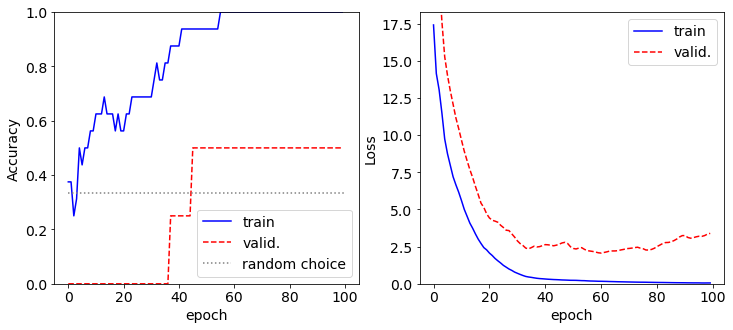

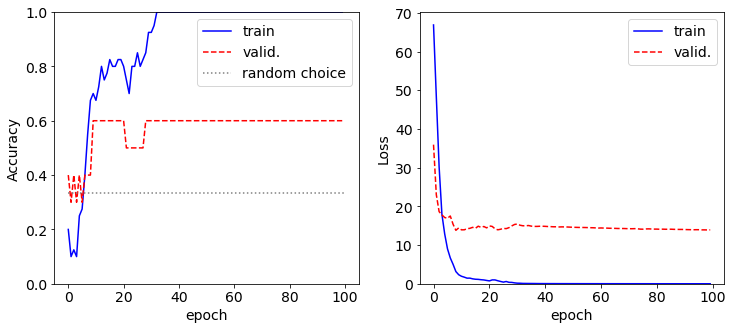

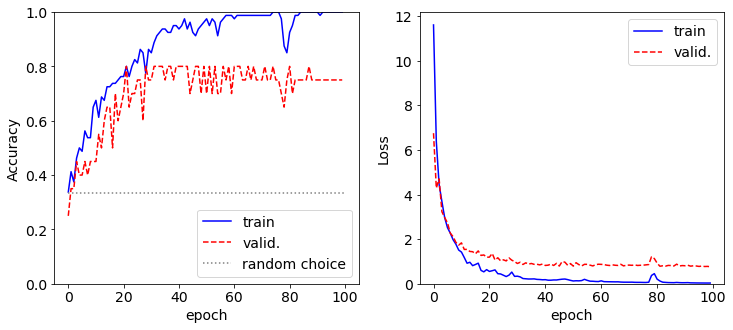

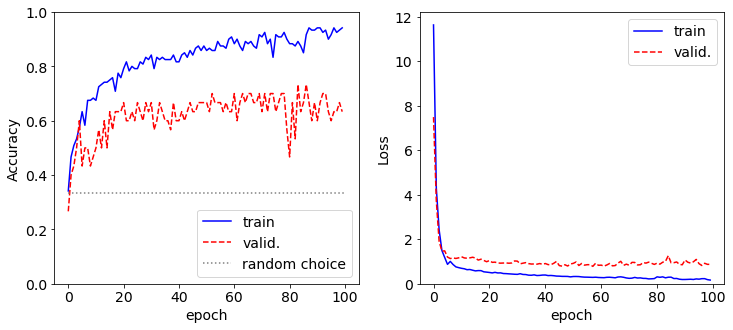

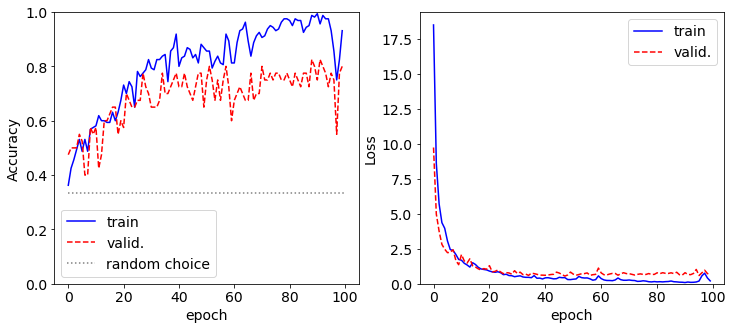

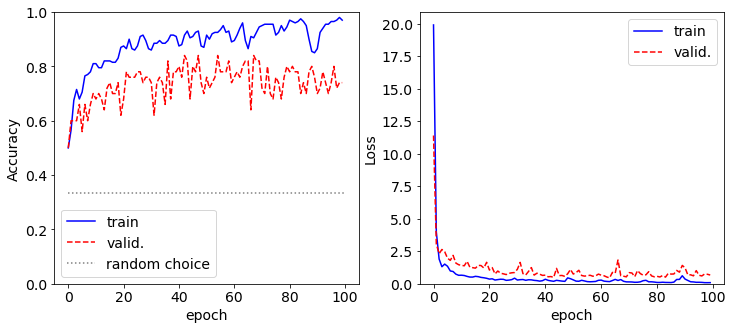

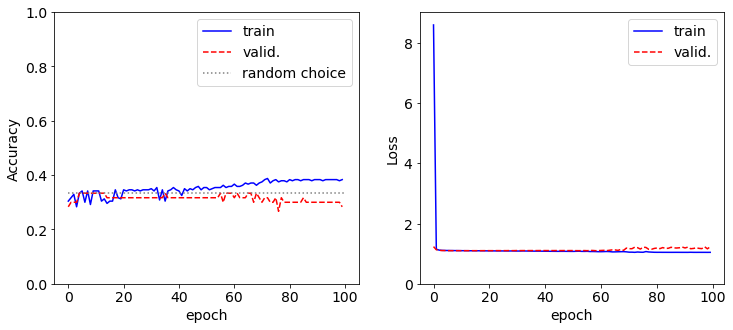

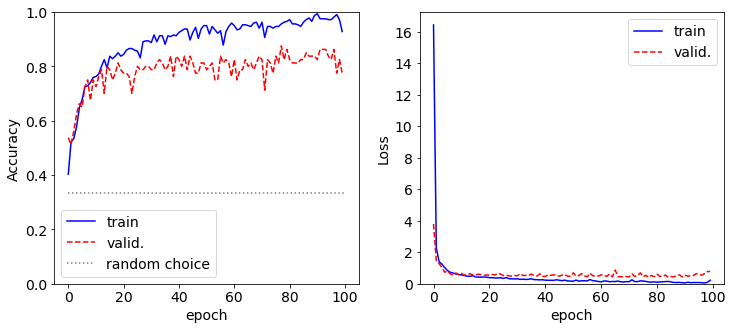

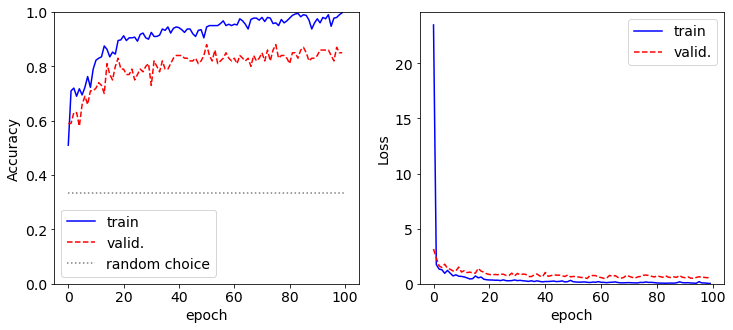

In [19]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

for i in range(len(dim)):
    Show_history(fit_CNN[i])

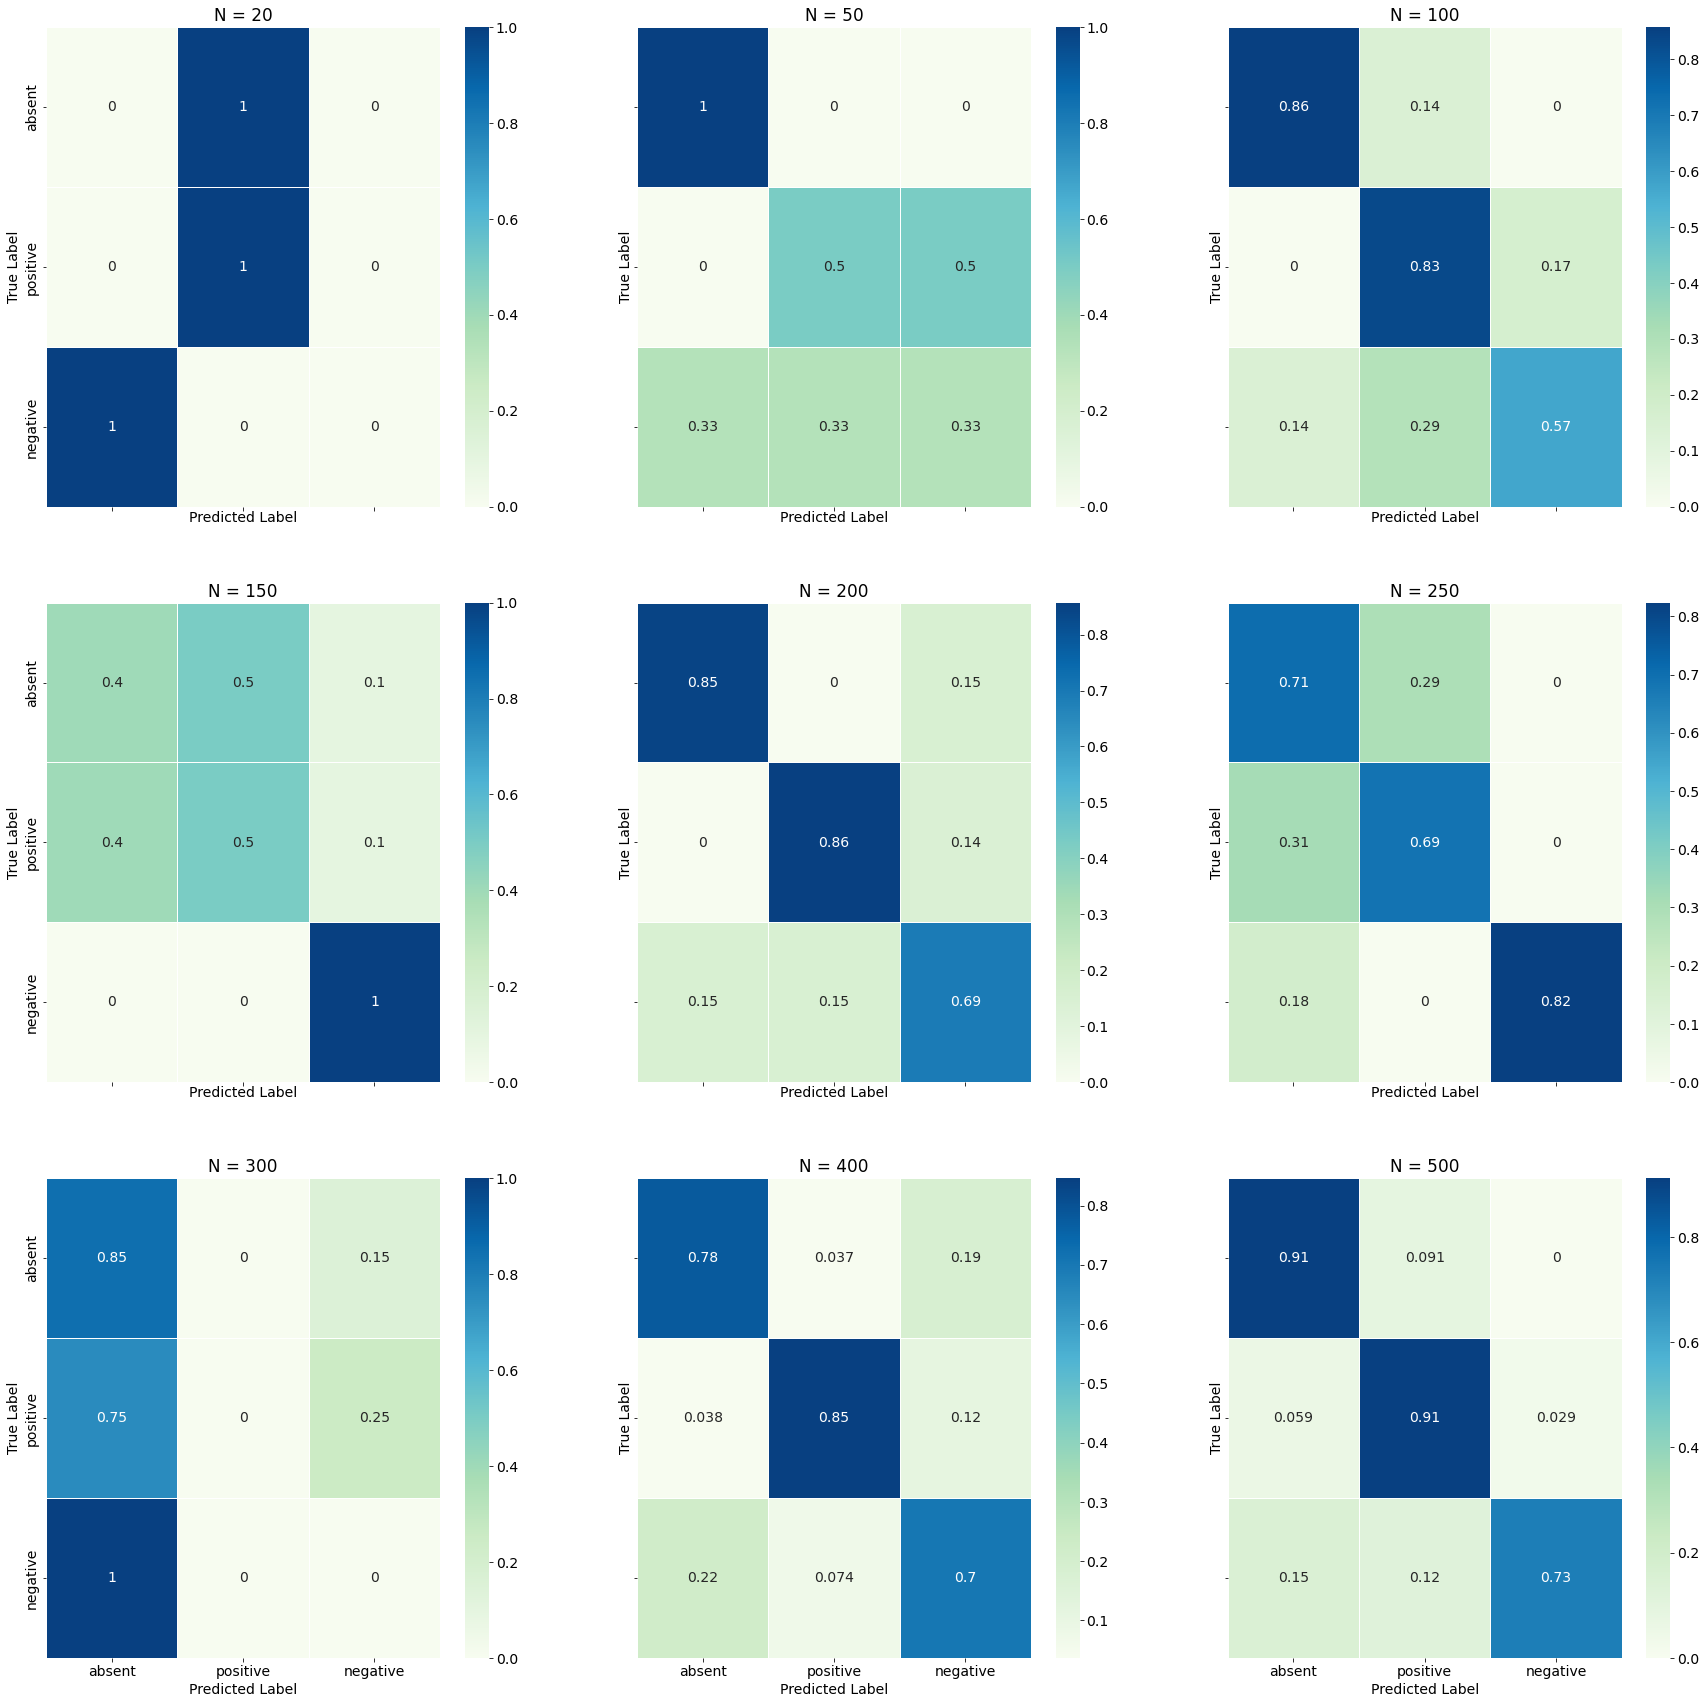

In [20]:
LABELS = ["absent","positive","negative"]
cmap="GnBu"

y_pred_val_CNN = [model_best[i].predict(x_val_CNN[i]) for i in range(len(dim))]

# Take the class with the highest probability from the val predictions
max_y_pred_val_CNN = [np.argmax(y_pred_val_CNN[i], axis=1) for i in range(len(dim))]
max_y_val_CNN      = [np.argmax(y_val_CNN[i], axis=1) for i in range(len(dim))]

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30,30), sharex=True, sharey=True)
col = row = 0
for i, N in enumerate(dim):
    show_confusion_matrix(ax[row, col], max_y_val_CNN[i], max_y_pred_val_CNN[i], f'N = {N}')
    col += 1
    if col == 3:
        col = 0
        row += 1
plt.show()

### Multiple iterations to take average and std

In [21]:
# function for the random step, using lambda construction
# int() for cleaner look and for mimicing a detector with finite resolution
jump = lambda drift, stdev: int(np.random.normal(drift,stdev))
def pattern(i,z,a):
    return int(a*np.sin((np.pi*i)/z))

    # pattern parameters: Z=nr of steps, A=amplitude
Z=12
A=500

# number of samples to be used
dim = [20, 50, 100, 150, 200, 250, 300, 400, 500]

# size of each sample of the timeseries
L=60
# step parameters: introduce small positive bias 
DX = 50
bias = 5

iterations = 2 # 10
train_accuracy = np.zeros(shape=(len(dim), iterations))
val_accuracy   = np.zeros(shape=(len(dim), iterations))

for z in range(iterations):
    x = np.array([np.zeros(shape=(i, 60)) for i in range(len(dim))])
    y = np.array([np.zeros(shape=(i    )) for i in range(len(dim))])
    # number of data samples
    for k, N in enumerate(dim):
        y[k] = [0] * N
        x[k] = np.array([[0] * L for i in range(N)])
        for i in range(N):
            if i>0:
                x[k][i][0] = x[k][i-1][-1] + jump(bias,DX)
            for j in range(1,L):
                x[k][i][j] = x[k][i][j-1] + jump(bias,DX)
            y[k][i] = i%3 
            if y[k][i]>0:
                j0 = np.random.randint(0,L-1-Z)
                sign = 3-2*y[k][i]
                for j in range(Z):
                    x[k][i][j0+j] += sign*pattern(j,Z,A)

    df = [get_df(x[i]) for i in range(len(dim))]
    x_features = [extract_features(df[i], #our dataframe
                               column_id='id', #sample id, from 0 to N
                               column_sort='time', #timestep, from 0 to t
                               column_kind=None, #we have only one feature
                               column_value='value', #value of input 
                               n_jobs=4) #number of cores
                  for i in range(len(dim))]

    #remove columns with NaN or inf
    for i in range(len(dim)):
        x_features[i].replace([np.inf, -np.inf], np.nan)
        x_features[i] = x_features[i].dropna(axis='columns')
    #split data into training and validation

    perc_train=0.8
    N_train=[int(perc_train*len(x[i]))  for i in range(len(dim))]
    x_train=[x_features[i][:N_train[i]] for i in range(len(dim))]
    y_train=[y[i][:N_train[i]]          for i in range(len(dim))]
    x_val  =[x_features[i][N_train[i]:] for i in range(len(dim))]
    y_val  =[y[i][N_train[i]:]          for i in range(len(dim))]
    N_val  =[len(x_val[i])              for i in range(len(dim))]


    for i in range(len(dim)):
        x_train[i].drop(columns=['value__sample_entropy'],inplace=True)
        x_val[i].drop(columns=['value__sample_entropy'],inplace=True)

    #define parameters for xgboost
    params = {'max_depth':6,'min_child_weight':1,\
            'learning_rate':0.3,'use_label_encoder':False}

    #build model with given params
    model = [XGBClassifier(**params) for i in range(len(dim))]

    #fit
    for i in range(len(dim)):
        model[i].fit(x_train[i].values,y_train[i])

    # plot tree here if needed

    #predict labels on training set
    y_pred_train = [model[i].predict(x_train[i]) for i in range(len(dim))]
    #predict labels on validation set
    y_pred_val = [model[i].predict(x_val[i]) for i in range(len(dim))]
    y_pred_val_soft = [model[i].predict_proba(x_val[i]) for i in range(len(dim))]
    #compute accuracies
    train_accuracy[:, z] = [accuracy_score(y_train[i],y_pred_train[i]) for i in range(len(dim))]
    val_accuracy[:, z]   = [accuracy_score(y_val[i],y_pred_val[i])     for i in range(len(dim))]


results_fits = pd.DataFrame({'validation':  np.concatenate([train_accuracy[i,:]                for i in range(len(dim))]),
                             'training':    np.concatenate([val_accuracy[i,:]                  for i in range(len(dim))]),
                             'group':       np.concatenate([np.repeat(f'{dim[i]}', iterations) for i in range(len(dim))])})
results_fits.to_csv('results_DATA/XGB_7.csv')


Feature Extraction: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]
/tmp/ipykernel_133921/458828280.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[i].drop(columns=['value__sample_entropy'],inplace=True)
/tmp/ipykernel_133921/458828280.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val[i].drop(columns=['value__sample_entropy'],inplace=True)
/tmp/ipykernel_133921/458828280.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

[15:22:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:22:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:22:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:22:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

Feature Extraction: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]
/tmp/ipykernel_133921/458828280.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[i].drop(columns=['value__sample_entropy'],inplace=True)
/tmp/ipykernel_133921/458828280.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val[i].drop(columns=['value__sample_entropy'],inplace=True)
/tmp/ipykernel_133921/458828280.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

[15:24:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:24:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:24:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:24:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

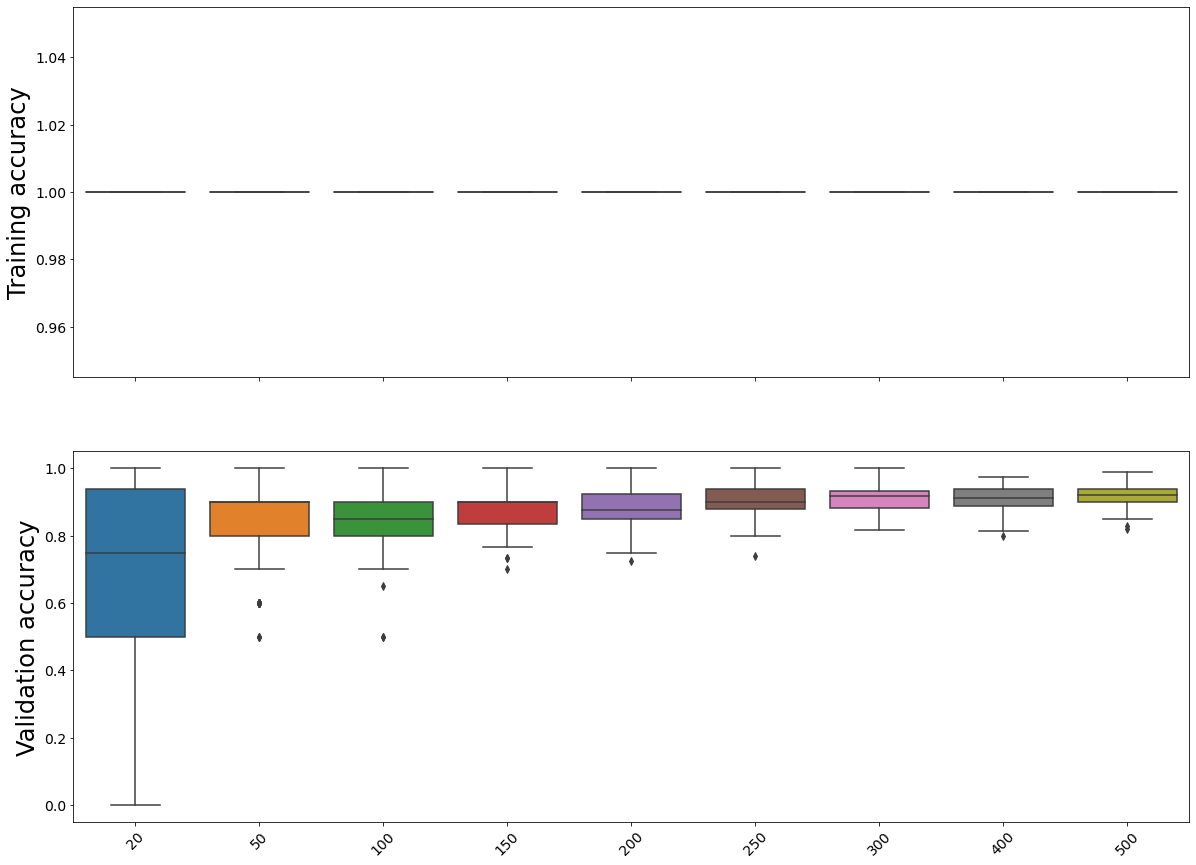

In [22]:
results_fits = pd.concat([pd.read_csv('results_DATA/XGB_'+str(i)+'.csv') for i in range(1,8)])

fig, ax = plt.subplots(nrows = 2, figsize=(20,15), sharex=True)

g1 = sns.boxplot(x='group', y='validation', data=results_fits, ax = ax[0] )
ax[0].set_xlabel('')
ax[0].set_ylabel('Training accuracy', fontsize='xx-large')
ax[0].tick_params(axis='x', labelrotation= 45)

g2 = sns.boxplot(x='group', y='training', data=results_fits, ax = ax[1] )
ax[1].set_xlabel('')
ax[1].set_ylabel('Validation accuracy', fontsize='xx-large')
ax[1].tick_params(axis='x', labelrotation= 45)

plt.show()

In [23]:
from statistics import mean

# function for the random step, using lambda construction
# int() for cleaner look and for mimicing a detector with finite resolution
jump = lambda drift, stdev: int(np.random.normal(drift,stdev))
def pattern(i,z,a):
    return int(a*np.sin((np.pi*i)/z))

# number of samples to be used
dim = [20, 50, 100, 150, 200, 250, 300, 400, 500]
    # pattern parameters: Z=nr of steps, A=amplitude
Z=12
A=500
# step parameters: introduce small positive bias 
DX = 50
bias = 5

iterations = 2 #10
train_accuracy_CNN = np.zeros(shape=(len(dim), iterations)) 
val_accuracy_CNN   = np.zeros(shape=(len(dim), iterations))

init_best        = 'GlorotUniform' #is GlorotUniform
reg_best         = regularizers.L1 #best_result.param_reg.values[0]
lam_best         = 0
kernel_size_best = [5,5,5] #best_result.param_kernel_size.values[0]

BATCH_SIZE = 5
EPOCHS = 100
dim = [20, 50, 100, 150, 200, 250, 300, 400, 500]


for z in range(iterations):
    x = np.array([np.zeros(shape=(i, 60)) for i in range(len(dim))])
    y = np.array([np.zeros(shape=(i    )) for i in range(len(dim))])

    # size of each sample of the timeseries
    L=60

    # number of data samples
    for k, N in enumerate(dim):
        y[k] = [0] * N
        x[k] = np.array([[0] * L for i in range(N)])
        for i in range(N):
            if i>0:
                x[k][i][0] = x[k][i-1][-1] + jump(bias,DX)
            for j in range(1,L):
                x[k][i][j] = x[k][i][j-1] + jump(bias,DX)
            y[k][i] = i%3 
            if y[k][i]>0:
                j0 = np.random.randint(0,L-1-Z)
                sign = 3-2*y[k][i]
                for j in range(Z):
                    x[k][i][j0+j] += sign*pattern(j,Z,A)
    
    N = [len(x[i])    for i in range(len(dim))]
    L = [len(x[i][0]) for i in range(len(dim))]

    x_CNN     =  [std_scale( x[i], N[i]) for i in range(len(dim))]

    perc_train=0.8
    N_train_CNN=[int(perc_train*len(x[i]))                for i in range(len(dim))]
    x_train_CNN=[x[i][:N_train_CNN[i]]                    for i in range(len(dim))]
    y_train_CNN=[to_categorical(y[i][:N_train_CNN[i]], 3) for i in range(len(dim))]
    x_val_CNN=[x[i][N_train_CNN[i]:]                      for i in range(len(dim))]
    y_val_CNN=[to_categorical(y[i][N_train_CNN[i]:],3)    for i in range(len(dim))]
    N_val_CNN=[len(x_val_CNN[i])                          for i in range(len(dim))]

    # Keras wants an additional dimension with a 1 at the end
    for i in range(len(dim)):
        x_train_CNN[i] = x_train_CNN[i].reshape(x_train_CNN[i].shape[0], L[i], 1)
        x_val_CNN[i] =  x_val_CNN[i].reshape(x_val_CNN[i].shape[0], L[i], 1)

    input_shape = [(L[i], 1) for i in range(len(dim))]

    model_best = [create_CNN(reg_best, lam_best, init_best, kernel_size_best, input_shape[i]) for i in range(len(dim))]

    fit_CNN = [model_best[i].fit(x_train_CNN[i],y_train_CNN[i],
                                epochs=EPOCHS,batch_size=BATCH_SIZE,
                                validation_data=(x_val_CNN[i], y_val_CNN[i]),
                                verbose=0, shuffle=True) for i in range(len(dim))]

    #compute accuracies
    train_accuracy[:, z] = [mean(fit_CNN[i].history['accuracy'][-10:-1]) for i in range(len(dim))]
    val_accuracy[:, z]   = [mean(fit_CNN[i].history['val_accuracy'][-10:-1]) for i in range(len(dim))]

results_fits = pd.DataFrame({'validation':  np.concatenate([train_accuracy[i,:]                for i in range(len(dim))]),
                             'training':    np.concatenate([val_accuracy[i,:]                  for i in range(len(dim))]),
                             'group':       np.concatenate([np.repeat(f'{dim[i]}', iterations) for i in range(len(dim))])})
results_fits.to_csv('results_DATA/CNN_7.csv')


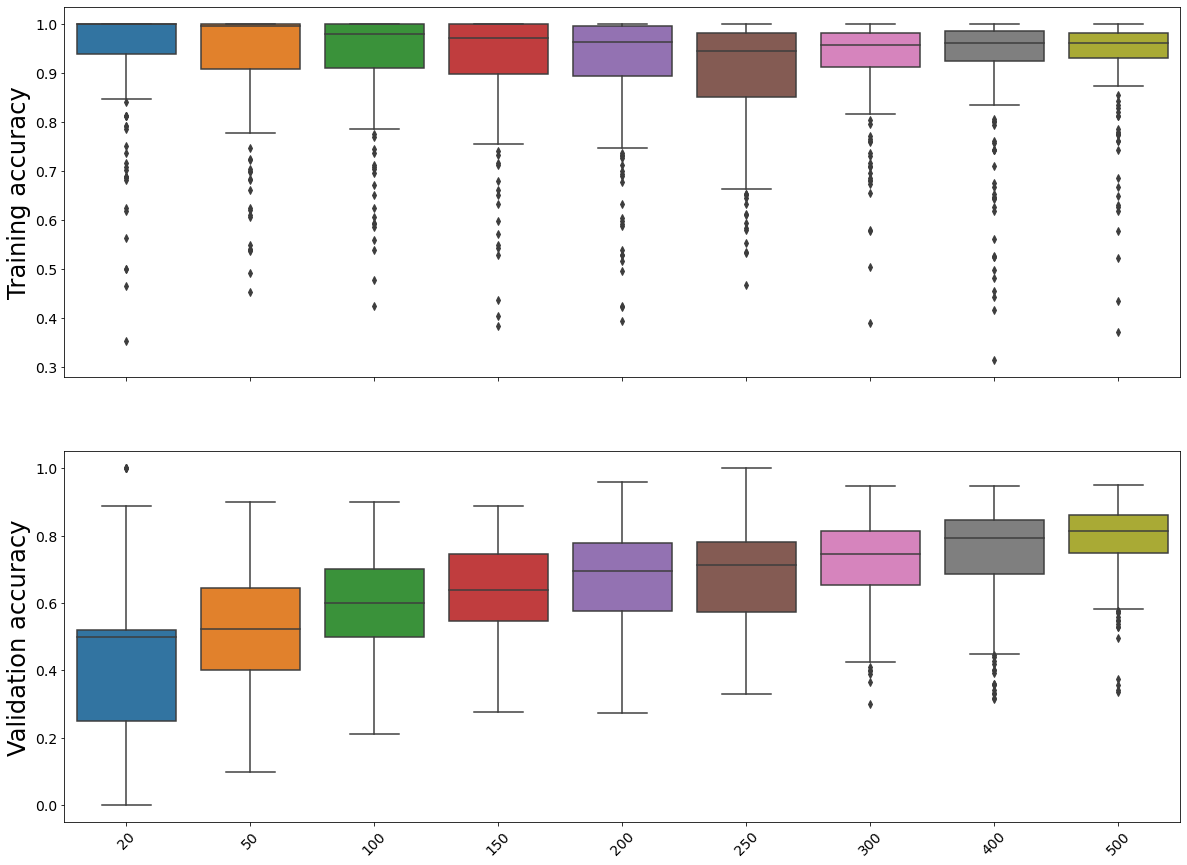

In [24]:
results_fits = pd.concat([pd.read_csv('results_DATA/CNN_'+str(i)+'.csv') for i in range(1,8)])

fig, ax = plt.subplots(nrows = 2, figsize=(20,15), sharex=True)

g1 = sns.boxplot(x='group', y='validation', data=results_fits, ax = ax[0] )
ax[0].set_xlabel('')
ax[0].set_ylabel('Training accuracy', fontsize='xx-large')
ax[0].tick_params(axis='x', labelrotation= 45)

g2 = sns.boxplot(x='group', y='training', data=results_fits, ax = ax[1] )
ax[1].set_xlabel('')
ax[1].set_ylabel('Validation accuracy', fontsize='xx-large')
ax[1].tick_params(axis='x', labelrotation= 45)

plt.show()

With a reduced number of sets the results with xgboost are significantly better than the results for a CNN.

--------------

# ------------------------------------------
### Part 1c: Combining XGBoost tree and CNN
# ------------------------------------------

In [25]:
def create_DNN(activation, dropout_rate, layers):
    model = Sequential()
    model.add(Dense(L,input_shape=input_shape,activation = activation, kernel_initializer = 'GlorotNormal'))
    for i in range(len(layers)):
        model.add(Dense(layers[i],activation = activation, kernel_initializer = 'GlorotNormal'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3,activation="softmax", kernel_initializer = 'GlorotNormal'))
    return model

def compile_model_DNN(optimizer=tf.keras.optimizers.Adam(), activation = "relu", dropout_rate = 0.2, layers = (20, 20)):
    # create the mode
    model=create_DNN(activation, dropout_rate, layers)
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

def std_scale(x, N):
    xm = x.mean(axis=1)
    print(N)
    for i in range(N):
        x[i] = x[i]-xm[i]
    return x/np.sqrt(x.var())

def reg_scale(x):
    for i in x.columns:
        x[i]/x[i].max()
    return x

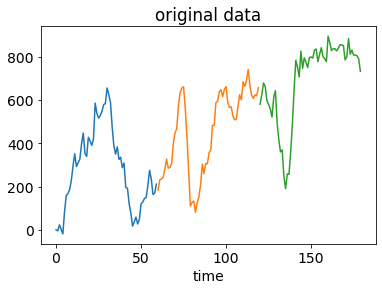

data:  10000


In [26]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"original data")

# note: here it does not need to be converted to the 3-bit version, a label remains y[i]=0,1,2
y = np.loadtxt(fnamey, dtype=int)
n_class = 3    #  = len(np.unique(y)) 
print('data: ',N)

df = get_df(x) 

In [27]:
x_features_total = extract_features(df, #our dataframe
                              column_id='id', #sample id, from 0 to N
                              column_sort='time', #timestep, from 0 to t
                              column_kind=None, #we have only one feature
                              column_value='value', #value of input 
                              n_jobs=4) #number of cores

Feature Extraction: 100%|██████████| 20/20 [06:07<00:00, 18.38s/it]


In [28]:
#x_features_total = x_features.copy()
x_features = x_features_total.copy()

In [29]:
#remove columns with NaN or inf
x_features = x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')

scaler = StandardScaler()
x_features = scaler.fit_transform(x_features)

N,L = len(x_features), len(x_features[0])

#split data into training and validation

perc_train=0.8
N_train = int(perc_train*N)
x_train = x_features[:N_train]#.to_numpy()
y_train = to_categorical(y[:N_train])
x_val = x_features[N_train:]#.to_numpy()
y_val = to_categorical(y[N_train:])
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)

nepoch = 100
batch_size = 50
input_shape = (L,)

print(input_shape)

N_train= 8000   N_val= 2000   n_class= 3
(496,)


In [30]:
'''# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn = compile_model_DNN)

dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
layers       = [(20,20), (30,30), (80,80), (20,30,20), (40,20), (10,20,30)]
param_grid = dict(dropout_rate=dropout_rate, layers=layers)

grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train, epochs=nepoch, batch_size = batch_size, shuffle = True, verbose = 0)

results = pd.DataFrame.from_dict(grid_result.cv_results_)
results.to_csv('results_DATA/GridSearchResults_DNN.csv')

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means  = grid_result.cv_results_['mean_test_score']
stds   = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))'''

'# call Keras scikit wrapper\nmodel_gridsearch = KerasClassifier(build_fn = compile_model_DNN)\n\ndropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]\nlayers       = [(20,20), (30,30), (80,80), (20,30,20), (40,20), (10,20,30)]\nparam_grid = dict(dropout_rate=dropout_rate, layers=layers)\n\ngrid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)\ngrid_result = grid.fit(x_train,y_train, epochs=nepoch, batch_size = batch_size, shuffle = True, verbose = 0)\n\nresults = pd.DataFrame.from_dict(grid_result.cv_results_)\nresults.to_csv(\'GridSearchResults_DNN.csv\')\n\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans  = grid_result.cv_results_[\'mean_test_score\']\nstds   = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))'

In [31]:
import ast

results     = pd.read_csv('results_DATA/GridSearchResults_DNN.csv')
best_result = results[results["rank_test_score"] == 1]

dropout_best    = best_result.param_dropout_rate.values[0]
layers_best     = ast.literal_eval(best_result.param_layers.values[0])

print(dropout_best, layers_best)

0.3 (20, 20)


Epoch 1/100
160/160 [==============================] - 1s 4ms/step - loss: 0.3412 - accuracy: 0.8641 - val_loss: 0.1960 - val_accuracy: 0.9250
Epoch 2/100
160/160 [==============================] - 1s 3ms/step - loss: 0.1773 - accuracy: 0.9415 - val_loss: 0.3204 - val_accuracy: 0.8600
Epoch 3/100
160/160 [==============================] - 1s 5ms/step - loss: 0.1300 - accuracy: 0.9546 - val_loss: 0.1615 - val_accuracy: 0.9385
Epoch 4/100
160/160 [==============================] - 1s 4ms/step - loss: 0.1036 - accuracy: 0.9646 - val_loss: 0.2458 - val_accuracy: 0.9295
Epoch 5/100
160/160 [==============================] - 1s 3ms/step - loss: 0.0846 - accuracy: 0.9700 - val_loss: 0.2394 - val_accuracy: 0.9100
Epoch 6/100
160/160 [==============================] - 1s 5ms/step - loss: 0.0766 - accuracy: 0.9745 - val_loss: 0.2046 - val_accuracy: 0.9290
Epoch 7/100
160/160 [==============================] - 1s 5ms/step - loss: 0.0594 - accuracy: 0.9812 - val_loss: 0.2041 - val_accuracy: 0.9465

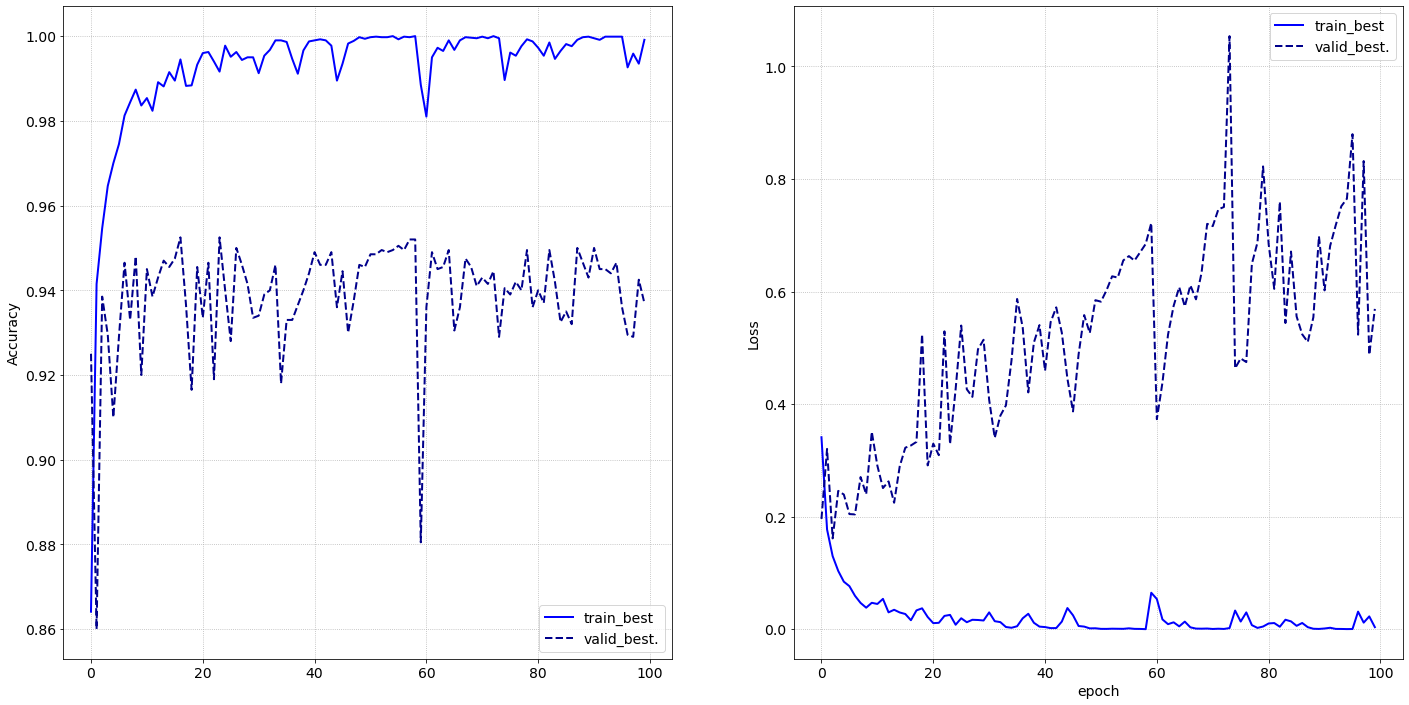

In [32]:
model_best      = compile_model_DNN(dropout_rate=dropout_best, layers=layers_best)
fit_best        = model_best.fit(x_train, y_train,
                                 epochs=100, batch_size=50,
                                 validation_data=(x_val,y_val),
                                 verbose=1)

fig,AX=plt.subplots(1,2,figsize=(24,12))
ax=AX[0]
ax.plot(fit_best.history['accuracy'    ],label="train_best",  lw = 2, ls = 'solid' , c = 'blue')
ax.plot(fit_best.history['val_accuracy'],label="valid_best.", lw = 2, ls = 'dashed', c = 'darkblue')
ax.legend(loc='lower right')
ax.grid(ls='dotted')
ax.set_ylabel('Accuracy')

ax=AX[1]
ax.plot(fit_best.history[    'loss'],label="train_best",  lw = 2, ls = 'solid' , c = 'blue')
ax.plot(fit_best.history['val_loss'],label="valid_best.", lw = 2, ls = 'dashed', c = 'darkblue')
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()
ax.grid(ls='dotted')

plt.show()

#### Training with only the main features

In [33]:
x_features = x_features_total.copy()

#remove columns with NaN or inf
x_features = x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')

#split data into training and validation

perc_train=0.8
N_train = int(perc_train*N)
x_train = x_features[:N_train]
y_train = y[:N_train]
x_val = x_features[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)

#get feature names
feature_names = x_features.columns.values

#define parameters for xgboost
params = {'max_depth':6,'min_child_weight':1,\
          'learning_rate':0.3,'use_label_encoder':False}

#build model with given params
model = XGBClassifier(**params)

#fit
model.fit(x_train.values,y_train)

#empty dict
feat_imp = {}
#get f importance from model
for i,f in enumerate(feature_names):
    feat_imp[f] = model.feature_importances_[i]
#sort features depending on their importances
feat_imp = dict(sorted(feat_imp.items(), reverse=True, key=lambda item: item[1]))

minval=0.005
print('------------- Feature importance sum = '+str(np.sum(model.feature_importances_)))
print('------------- Showing feature with importance > '+str(minval))
for i,k in enumerate(feat_imp.keys()):
    if feat_imp[k]>minval: print(i+1,k,feat_imp[k])

#get feature names given importance order
features = list(feat_imp.keys())

x_main_features = x_features[features[0:4]]

N_train= 8000   N_val= 2000   n_class= 3
[15:35:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------------- Feature importance sum = 1.0
------------- Showing feature with importance > 0.005
1 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0 0.16528384
2 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4 0.13110887
3 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0 0.103979625
4 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0 0.1035496
5 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6 0.0644738
6 value__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.026158452
7 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0 0.017058121
8 value__change_quantiles__f_agg_"var"__isabs_False__qh_

In [34]:
#remove columns with NaN or inf
x_main_features = x_main_features.replace([np.inf, -np.inf], np.nan)
x_main_features = x_main_features.dropna(axis='columns')

scaler = StandardScaler()
x_main_features = scaler.fit_transform(x_main_features)

N,L = len(x_main_features), len(x_main_features[0])

N_train= 8000   N_val= 2000   n_class= 3
(4,)
0.3 (40, 20)
Epoch 1/100
160/160 [==============================] - 1s 2ms/step - loss: 0.5005 - accuracy: 0.8279 - val_loss: 0.4245 - val_accuracy: 0.8335
Epoch 2/100
160/160 [==============================] - 0s 2ms/step - loss: 0.4511 - accuracy: 0.8364 - val_loss: 0.4215 - val_accuracy: 0.8385
Epoch 3/100
160/160 [==============================] - 0s 3ms/step - loss: 0.4446 - accuracy: 0.8385 - val_loss: 0.4167 - val_accuracy: 0.8380
Epoch 4/100
160/160 [==============================] - 0s 3ms/step - loss: 0.4422 - accuracy: 0.8372 - val_loss: 0.4143 - val_accuracy: 0.8395
Epoch 5/100
160/160 [==============================] - 0s 3ms/step - loss: 0.4369 - accuracy: 0.8375 - val_loss: 0.4120 - val_accuracy: 0.8395
Epoch 6/100
160/160 [==============================] - 0s 2ms/step - loss: 0.4339 - accuracy: 0.8382 - val_loss: 0.4153 - val_accuracy: 0.8380
Epoch 7/100
160/160 [==============================] - 0s 2ms/step - loss: 0.4344 -

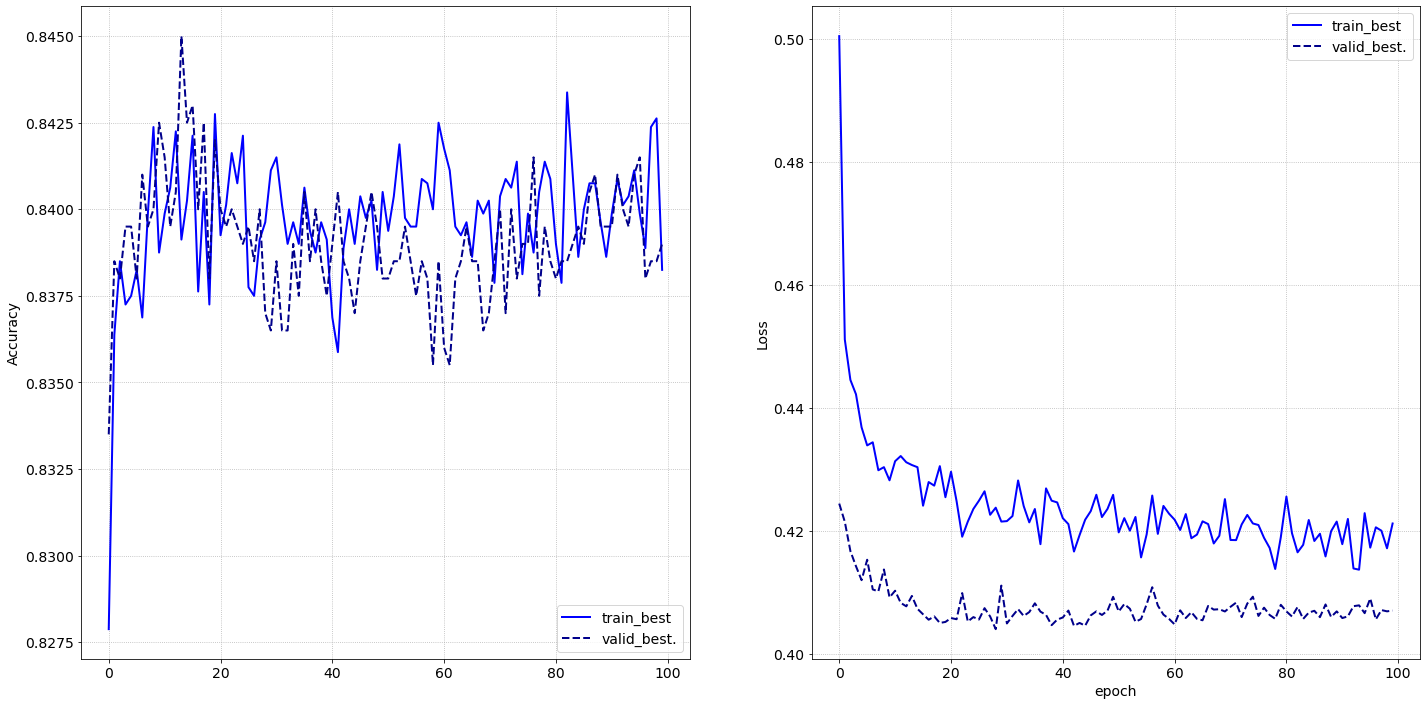

In [35]:
#split data into training and validation

perc_train=0.8
N_train = int(perc_train*N)
x_train = x_main_features[:N_train]#.to_numpy()
y_train = to_categorical(y[:N_train])
x_val = x_main_features[N_train:]#.to_numpy()
y_val = to_categorical(y[N_train:])
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)

nepoch = 100
batch_size = 50
input_shape = (L,)

print(input_shape)
'''
# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn = compile_model_DNN)

dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
layers       = [(20,20), (30,30), (80,80), (20,30,20), (40,20), (10,20,30)]
param_grid = dict(dropout_rate=dropout_rate, layers=layers)

grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train, epochs=nepoch, batch_size = batch_size, shuffle = True, verbose = 0)

results = pd.DataFrame.from_dict(grid_result.cv_results_)
results.to_csv('results_DATA/GridSearchResults_Features_DNN.csv')

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means  = grid_result.cv_results_['mean_test_score']
stds   = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
'''
results     = pd.read_csv('results_DATA/GridSearchResults_Features_DNN.csv')
best_result = results[results["rank_test_score"] == 1]

dropout_best    = best_result.param_dropout_rate.values[0]
layers_best     = ast.literal_eval(best_result.param_layers.values[0])

print(dropout_best, layers_best)

model_best      = compile_model_DNN(dropout_rate=dropout_best, layers=layers_best)
fit_best        = model_best.fit(x_train, y_train,
                                 epochs=100, batch_size=50,
                                 validation_data=(x_val,y_val),
                                 verbose=1)

fig,AX=plt.subplots(1,2,figsize=(24,12))
ax=AX[0]
ax.plot(fit_best.history['accuracy'    ],label="train_best",  lw = 2, ls = 'solid' , c = 'blue')
ax.plot(fit_best.history['val_accuracy'],label="valid_best.", lw = 2, ls = 'dashed', c = 'darkblue')
ax.legend(loc='lower right')
ax.grid(ls='dotted')
ax.set_ylabel('Accuracy')

ax=AX[1]
ax.plot(fit_best.history[    'loss'],label="train_best",  lw = 2, ls = 'solid' , c = 'blue')
ax.plot(fit_best.history['val_loss'],label="valid_best.", lw = 2, ls = 'dashed', c = 'darkblue')
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()
ax.grid(ls='dotted')

plt.show()

# -----------------------------------
### Part 1b: Feature importance
# -----------------------------------

For task a) we have seen during the lesson that XGBoost finds some features more relevant than
others. Find the description of those features in the documentation and try to provide an
explanation of why they are relevant for that problem.

In [36]:
# #get feature names
# feature_names = x_features.columns.values
# #empty dict
# feat_imp = {}
# #get f importance from model
# for i,f in enumerate(feature_names):
#     feat_imp[f] = model.feature_importances_[i]
# #sort features depending on their importances
# feat_imp = dict(sorted(feat_imp.items(), reverse=True, key=lambda item: item[1]))

# # all_features = pd.DataFrame(feat_imp.keys())
# # all_features.to_csv('results_DATA/all_features.csv')

data:  10000


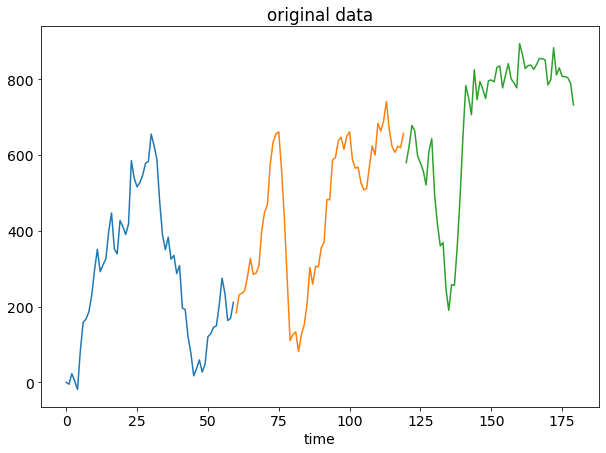

In [37]:
#Looking through the data

str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])
y = np.loadtxt(fnamey, dtype=int)
n_class = 3    #  = len(np.unique(y)) 
print('data: ',N)

def Show_data(x,L,s="data"):
    plt.figure(figsize=(10,7))
    plt.plot(np.arange(L),x[0])
    plt.plot(np.arange(L,2*L),x[1])
    plt.plot(np.arange(2*L,3*L),x[2])
    plt.title(s)
    plt.xlabel("time")
    plt.show()

Show_data(x,L,"original data")

In [38]:
all_features = pd.read_csv('results_DATA/all_features.csv')

#Printing the list of features based on importance threshold
minval=0.004
print('------------- Feature importance sum = '+str(np.sum(model.feature_importances_)))
print('------------- Showing feature with importance > '+str(minval))
for i,k in enumerate(feat_imp.keys()):
    if feat_imp[k]>minval: print(i+1,k,feat_imp[k])


------------- Feature importance sum = 1.0
------------- Showing feature with importance > 0.004
1 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0 0.16528384
2 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4 0.13110887
3 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0 0.103979625
4 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0 0.1035496
5 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6 0.0644738
6 value__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.026158452
7 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0 0.017058121
8 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2 0.013211804
9 value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.012973229
10 value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.011110099
11 value__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20) 0.009836954
12 value__linear_trend__attr_"std

First let's consider the most important features whith importance > 0.1

1. value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0 0.1714831
2. value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4 0.13817137
3. value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0 0.1103316
4. value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0 0.10824725

Based on tsfreash documents, we have:

![Picture title](image-20220401-232952.png)

#### The Question:

change_quantiles caclulates the average abs. of changes of the series x.
According the the importance list, all first 4 most important features are the kind of change_quantiles only with differnt limits for quantile of the corridor. 
But why a kind of variable which is the avg. abs. of change in x is important for this kind of data processed with this specific model?

#### Our Answer:

Fisrt let's build the change_quantiles function:



In [39]:
def change_quan(x, ql, qh, isabs):
    quan=[]
    for i in range(len(x)):
        if isabs==True: delta_x = np.abs(x[i][1:-1] - x[i][:-2])
        else: delta_x = x[i][1:-1] - x[i][:-2]
        delta_x = np.sort(delta_x)
        delta_x = delta_x[int(ql*len(delta_x)): int(qh*len(delta_x))]
        quan.append(np.average(delta_x))
    return quan

In [40]:
quan_1 = np.array(change_quan(x, 0, 1,   False))
quan_2 = np.array(change_quan(x, 0.4, 1, False))
quan_3 = np.array(change_quan(x, 0, 0.4, False))
quan_4 = np.array(change_quan(x, 0, 0.6, False))

zero_label =  np.array([quan_1[y==0], quan_2[y==0], quan_3[y==0], quan_4[y==0]])
one_label  =  np.array([quan_1[y==1], quan_2[y==1], quan_3[y==1], quan_4[y==1]])
two_label  =  np.array([quan_1[y==2], quan_2[y==2], quan_3[y==2], quan_4[y==2]])

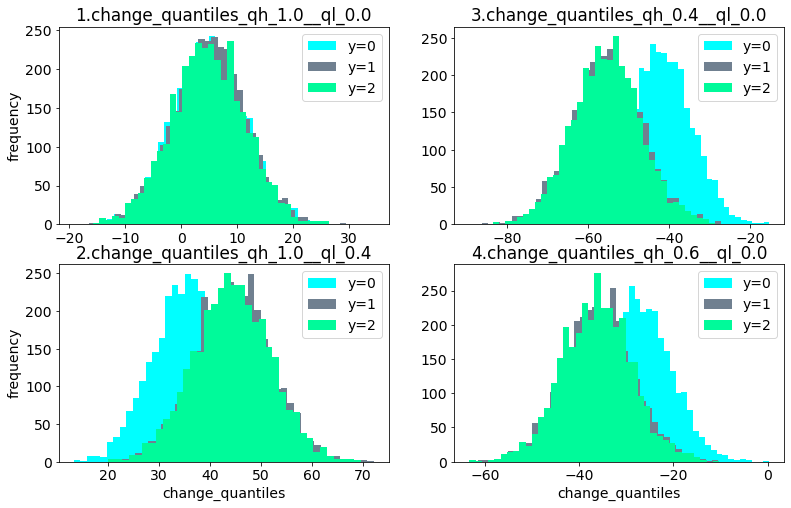

In [41]:
fig, AX = plt.subplots(2,2, figsize=(13,8))

ax = AX[0,0]
ax.hist(zero_label[0], color='cyan', label='y=0', bins='auto')
ax.hist(one_label [0], color='slategrey', label='y=1', bins='auto')
ax.hist(two_label [0], color='mediumspringgreen', label='y=2', bins='auto')
ax.set_title("1.change_quantiles_qh_1.0__ql_0.0")
# ax.set_xlabel("change_quantiles")
ax.set_ylabel("frequency")
ax.legend(loc='best')

ax = AX[1,0]
ax.hist(zero_label[1], color='cyan', label='y=0', bins='auto')
ax.hist(one_label [1], color='slategrey', label='y=1', bins='auto')
ax.hist(two_label [1], color='mediumspringgreen', label='y=2', bins='auto')
ax.set_title("2.change_quantiles_qh_1.0__ql_0.4")
ax.set_xlabel("change_quantiles")
ax.set_ylabel("frequency")
ax.legend(loc='best')

ax = AX[0,1]
ax.hist(zero_label[2], color='cyan', label='y=0', bins='auto')
ax.hist(one_label[2], color='slategrey', label='y=1', bins='auto')
ax.hist(two_label[2], color='mediumspringgreen', label='y=2', bins='auto')
ax.set_title("3.change_quantiles_qh_0.4__ql_0.0")
# ax.set_xlabel("change_quantiles")
# ax.set_ylabel("frequency")
ax.legend(loc='best')

ax = AX[1,1]
ax.hist(zero_label[3], color='cyan', label='y=0', bins='auto')
ax.hist(one_label [3], color='slategrey', label='y=1', bins='auto')
ax.hist(two_label [3], color='mediumspringgreen', label='y=2', bins='auto')
ax.set_title("4.change_quantiles_qh_0.6__ql_0.0")
ax.set_xlabel("change_quantiles")
# ax.set_ylabel("frequency")
ax.legend(loc='best')

We have plotted the distribution of change_quantile for its for differnet versions. We can see that the second, third and fourth features clearly are founnd seperate for label 0 and label 2. It is a little odd that feautre one, the most important feature according to tsfresh is found similar for all three labels!
The reason why this change_quantile is the proper feature for this kind is that we have different overall amount of fluctuations for each label.

Also it's not bad to mention that unlike what we get in the importance table, when we consider isabs=True in the function change_quan(x, ql, qh, isabs), more relevant results are obtained! Let's plot the previous graphs when we take the absolute value of changes in x:

In [42]:
quan_1 = np.array(change_quan(x, 0, 1,   True))
quan_2 = np.array(change_quan(x, 0.4, 1, True))
quan_3 = np.array(change_quan(x, 0, 0.4, True))
quan_4 = np.array(change_quan(x, 0, 0.6, True))

zero_label =  np.array([quan_1[y==0], quan_2[y==0], quan_3[y==0], quan_4[y==0]])
one_label  =  np.array([quan_1[y==1], quan_2[y==1], quan_3[y==1], quan_4[y==1]])
two_label  =  np.array([quan_1[y==2], quan_2[y==2], quan_3[y==2], quan_4[y==2]])

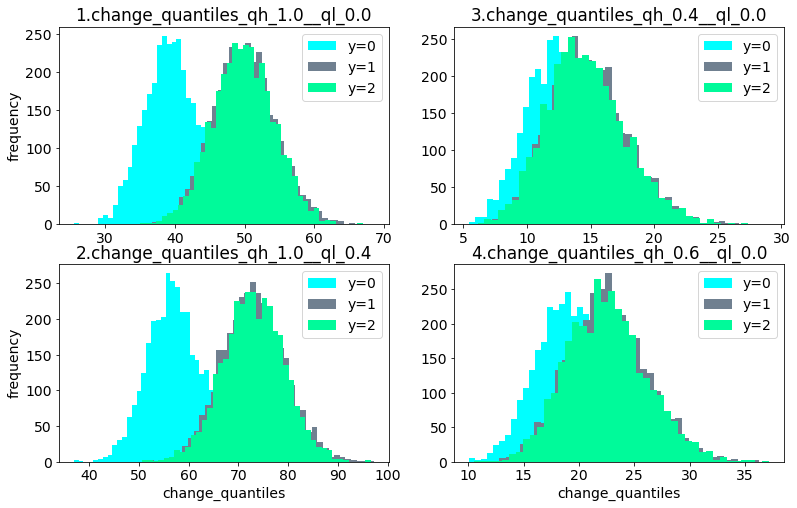

In [43]:
fig, AX = plt.subplots(2,2, figsize=(13,8))

ax = AX[0,0]
ax.hist(zero_label[0], color='cyan', label='y=0', bins='auto')
ax.hist(one_label [0], color='slategrey', label='y=1', bins='auto')
ax.hist(two_label [0], color='mediumspringgreen', label='y=2', bins='auto')
ax.set_title("1.change_quantiles_qh_1.0__ql_0.0")
# ax.set_xlabel("change_quantiles")
ax.set_ylabel("frequency")
ax.legend(loc='best')

ax = AX[1,0]
ax.hist(zero_label[1], color='cyan', label='y=0', bins='auto')
ax.hist(one_label [1], color='slategrey', label='y=1', bins='auto')
ax.hist(two_label [1], color='mediumspringgreen', label='y=2', bins='auto')
ax.set_title("2.change_quantiles_qh_1.0__ql_0.4")
ax.set_xlabel("change_quantiles")
ax.set_ylabel("frequency")
ax.legend(loc='best')

ax = AX[0,1]
ax.hist(zero_label[2], color='cyan', label='y=0', bins='auto')
ax.hist(one_label[2], color='slategrey', label='y=1', bins='auto')
ax.hist(two_label[2], color='mediumspringgreen', label='y=2', bins='auto')
ax.set_title("3.change_quantiles_qh_0.4__ql_0.0")
# ax.set_xlabel("change_quantiles")
# ax.set_ylabel("frequency")
ax.legend(loc='best')

ax = AX[1,1]
ax.hist(zero_label[3], color='cyan', label='y=0', bins='auto')
ax.hist(one_label [3], color='slategrey', label='y=1', bins='auto')
ax.hist(two_label [3], color='mediumspringgreen', label='y=2', bins='auto')
ax.set_title("4.change_quantiles_qh_0.6__ql_0.0")
ax.set_xlabel("change_quantiles")
# ax.set_ylabel("frequency")
ax.legend(loc='best')

As one can see, the most important feature, when taking the absolute value
of changes perfectly seperates label 0 from label 2. It should be mentioned that with or without the taking the absolute value, label 1 and label 2 are always attached together.

# ------------------------------
# Ex 2: simplest model
# ------------------------------

In [44]:
np.random.seed(132)

CASE = 2

S = 2
N = 4000
N_train = 2000
N_test  = N - N_train
x = S*(2*np.random.rand(N,2)-1)
y = np.zeros(N).astype(int)

for n in range(N):
    if CASE==1:
        if x[n,1]<-0.6 and x[n,0]>-0.2: y[n]=1
        if x[n,1]>0.4 and x[n,0]<-0.8: y[n]=1
        if x[n,1]>1.0 and x[n,0]>0.8: y[n]=1
    elif CASE==2:
        if x[n,1]<0 and x[n,0]>0.5: y[n]=1
        if x[n,1]>0 and np.sqrt((x[n,0]+0.3)**2+x[n,1]**2)<1.5: y[n]=1

x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]

[ 1.1236156  -0.47542183] 1
[1.31455057 1.12673117] 0
[ 1.20638847 -0.5723929 ] 1
[ 1.84848774 -0.57504058] 1
[1.27432162 1.62075204] 0


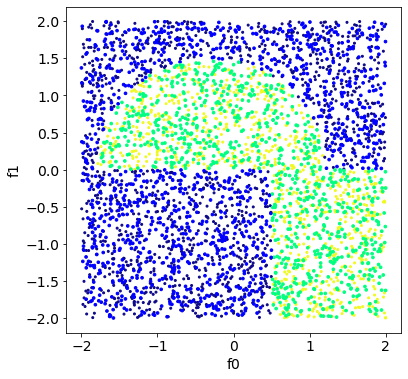

In [45]:
def scat(x,y,s=4,cmap="plasma"):
    plt.scatter(x[:,0],x[:,1],s=s,c=y,cmap=cmap)
    plt.xlabel("f0")
    plt.ylabel("f1")

for n in range(5):
    print(x[n],y[n])

plt.figure(figsize=(6,6))
scat(x_train,y_train)
scat(x_test,y_test,cmap="winter",s=7)
plt.show()

In [47]:
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier

clf=GradientBoostingClassifier()
clf.fit(x_train,y_train)
clf.score(x_test, y_test)

0.9825

In [48]:
"""

n_estimators = range(1,10,1)
learning_rate = [0.2, 0.3, 0.4]
gamma = [0, 0.1 , 1]
max_depth = [1,2,4,6,8]
reg_lambda = [0.1,1,10]
min_child_weight = [0, 1, 10]
max_delta_step = [0, 1, 10]
subsamples = [0,0.5]

param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate, min_split_loss=gamma, max_depth=max_depth,
                  reg_lambda=reg_lambda,min_child_weight=min_child_weight,max_delta_step=max_delta_step, subsample=subsamples)

model_gridsearch = XGBClassifier(seed=1,
                       #objective='binary:logistic',
                       objective="reg:squarederror",eval_metric="rmse", use_label_encoder=False)

grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train)
"""

'\n\nn_estimators = range(1,10,1)\nlearning_rate = [0.2, 0.3, 0.4]\ngamma = [0, 0.1 , 1]\nmax_depth = [1,2,4,6,8]\nreg_lambda = [0.1,1,10]\nmin_child_weight = [0, 1, 10]\nmax_delta_step = [0, 1, 10]\nsubsamples = [0,0.5]\n\nparam_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate, min_split_loss=gamma, max_depth=max_depth,\n                  reg_lambda=reg_lambda,min_child_weight=min_child_weight,max_delta_step=max_delta_step, subsample=subsamples)\n\nmodel_gridsearch = XGBClassifier(seed=1,\n                       #objective=\'binary:logistic\',\n                       objective="reg:squarederror",eval_metric="rmse", use_label_encoder=False)\n\ngrid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)\ngrid_result = grid.fit(x_train,y_train)\n'

In [49]:
#results = pd.DataFrame.from_dict(grid_result.cv_results_)
#results.to_csv('results_DATA/GridSearchResults_4.csv')
results = pd.read_csv("results_DATA/GridSearchResults_4.csv")

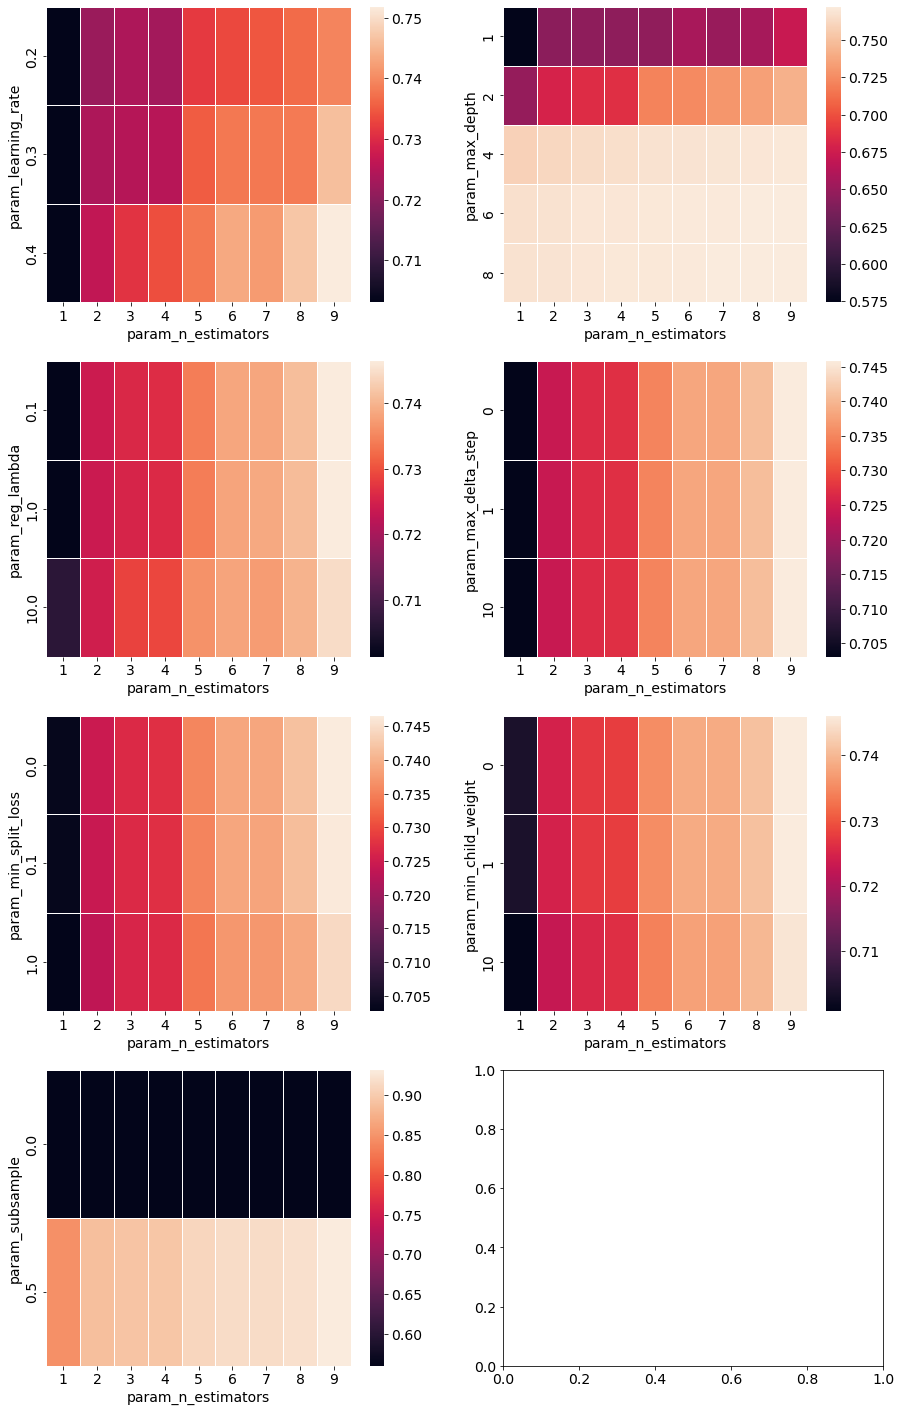

In [50]:
import seaborn as sns
fig, ax = plt.subplots(4,2, figsize = (15,25))
# takes the mean in this way
sns.heatmap(results.pivot_table('mean_test_score','param_learning_rate','param_n_estimators'), linewidth=0.5, ax=ax[0,0])
sns.heatmap(results.pivot_table('mean_test_score','param_max_depth','param_n_estimators'), linewidth=0.5, ax=ax[0,1])
sns.heatmap(results.pivot_table('mean_test_score','param_reg_lambda','param_n_estimators'), linewidth=0.5, ax=ax[1,0])
sns.heatmap(results.pivot_table('mean_test_score','param_max_delta_step','param_n_estimators'), linewidth=0.5, ax=ax[1,1])
sns.heatmap(results.pivot_table('mean_test_score','param_min_split_loss','param_n_estimators'), linewidth=0.5, ax=ax[2,0])
sns.heatmap(results.pivot_table('mean_test_score','param_min_child_weight','param_n_estimators'), linewidth=0.5, ax=ax[2,1])
sns.heatmap(results.pivot_table('mean_test_score','param_subsample','param_n_estimators'), linewidth=0.5, ax=ax[3,0])
plt.show()

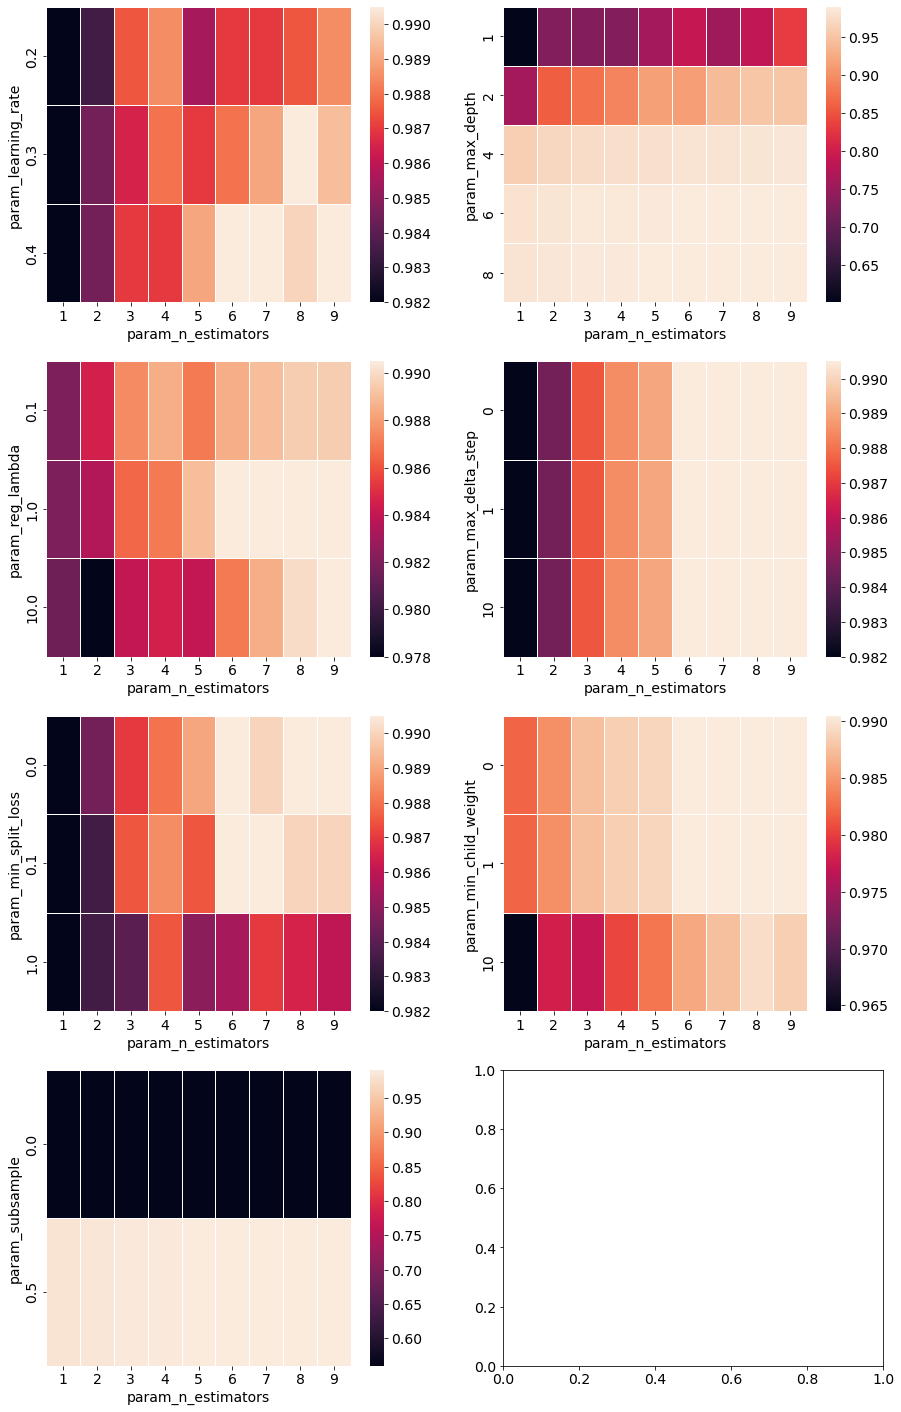

In [51]:
fig, ax = plt.subplots(4,2, figsize = (15,25))
# takes the max in this way
sns.heatmap(results.groupby(['param_learning_rate','param_n_estimators']).max('mean_test_score')['mean_test_score'].unstack(), linewidth=0.5, ax=ax[0,0])
sns.heatmap(results.groupby(['param_max_depth','param_n_estimators']).max('mean_test_score')['mean_test_score'].unstack(), linewidth=0.5, ax=ax[0,1])
sns.heatmap(results.groupby(['param_reg_lambda','param_n_estimators']).max('mean_test_score')['mean_test_score'].unstack(), linewidth=0.5, ax=ax[1,0])
sns.heatmap(results.groupby(['param_max_delta_step','param_n_estimators']).max('mean_test_score')['mean_test_score'].unstack(), linewidth=0.5, ax=ax[1,1])
sns.heatmap(results.groupby(['param_min_split_loss','param_n_estimators']).max('mean_test_score')['mean_test_score'].unstack(), linewidth=0.5, ax=ax[2,0])
sns.heatmap(results.groupby(['param_min_child_weight','param_n_estimators']).max('mean_test_score')['mean_test_score'].unstack(), linewidth=0.5, ax=ax[2,1])
sns.heatmap(results.groupby(['param_subsample','param_n_estimators']).max('mean_test_score')['mean_test_score'].unstack(), linewidth=0.5, ax=ax[3,0])
plt.show()


In [52]:
best_simple = results[(results["param_n_estimators"]==6)&
                      (results["param_reg_lambda"]==1)&
                      (results["param_min_split_loss"]<1)&
                      (results["param_learning_rate"]==.4)&
                      (results["param_max_depth"]==6)&
                      (results["param_subsample"]==.5)&
                      (results["param_min_child_weight"]<10) ]

print("Parameters of the best simple XGBoost model")
id = best_simple['mean_test_score'].idxmax()
print(results.iloc[id]["params"])

Parameters of the best simple XGBoost model
{'learning_rate': 0.4, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 0, 'min_split_loss': 0.1, 'n_estimators': 6, 'reg_lambda': 1, 'subsample': 0.5}


In [53]:
def classify(clf=GradientBoostingClassifier(),show=False):
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    if CASE<10: print("errors: {:.2f}%".format(100*(1-clf.score(x_test, y_test))))

    dx = 0.02
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,2))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    plt.figure(figsize=(6,6))
    plt.title(str(clf))

    scat(x_plot,y_plot,cmap="winter",s=1)
    scat(x_train,y_train,s=7)
    plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(3,1,figsize=(30, 30))
        for i in range(min(3,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=300, pad_inches=0.02)   
        plt.show()

[15:40:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
errors: 2.10%


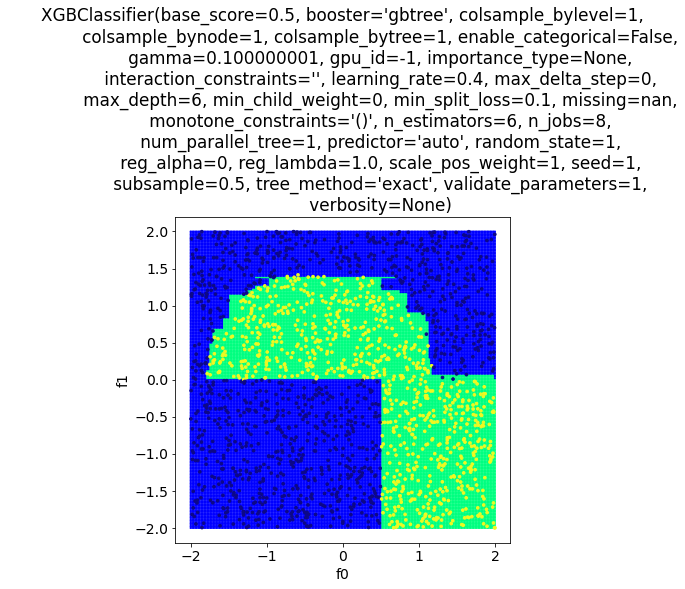

num_trees= 6


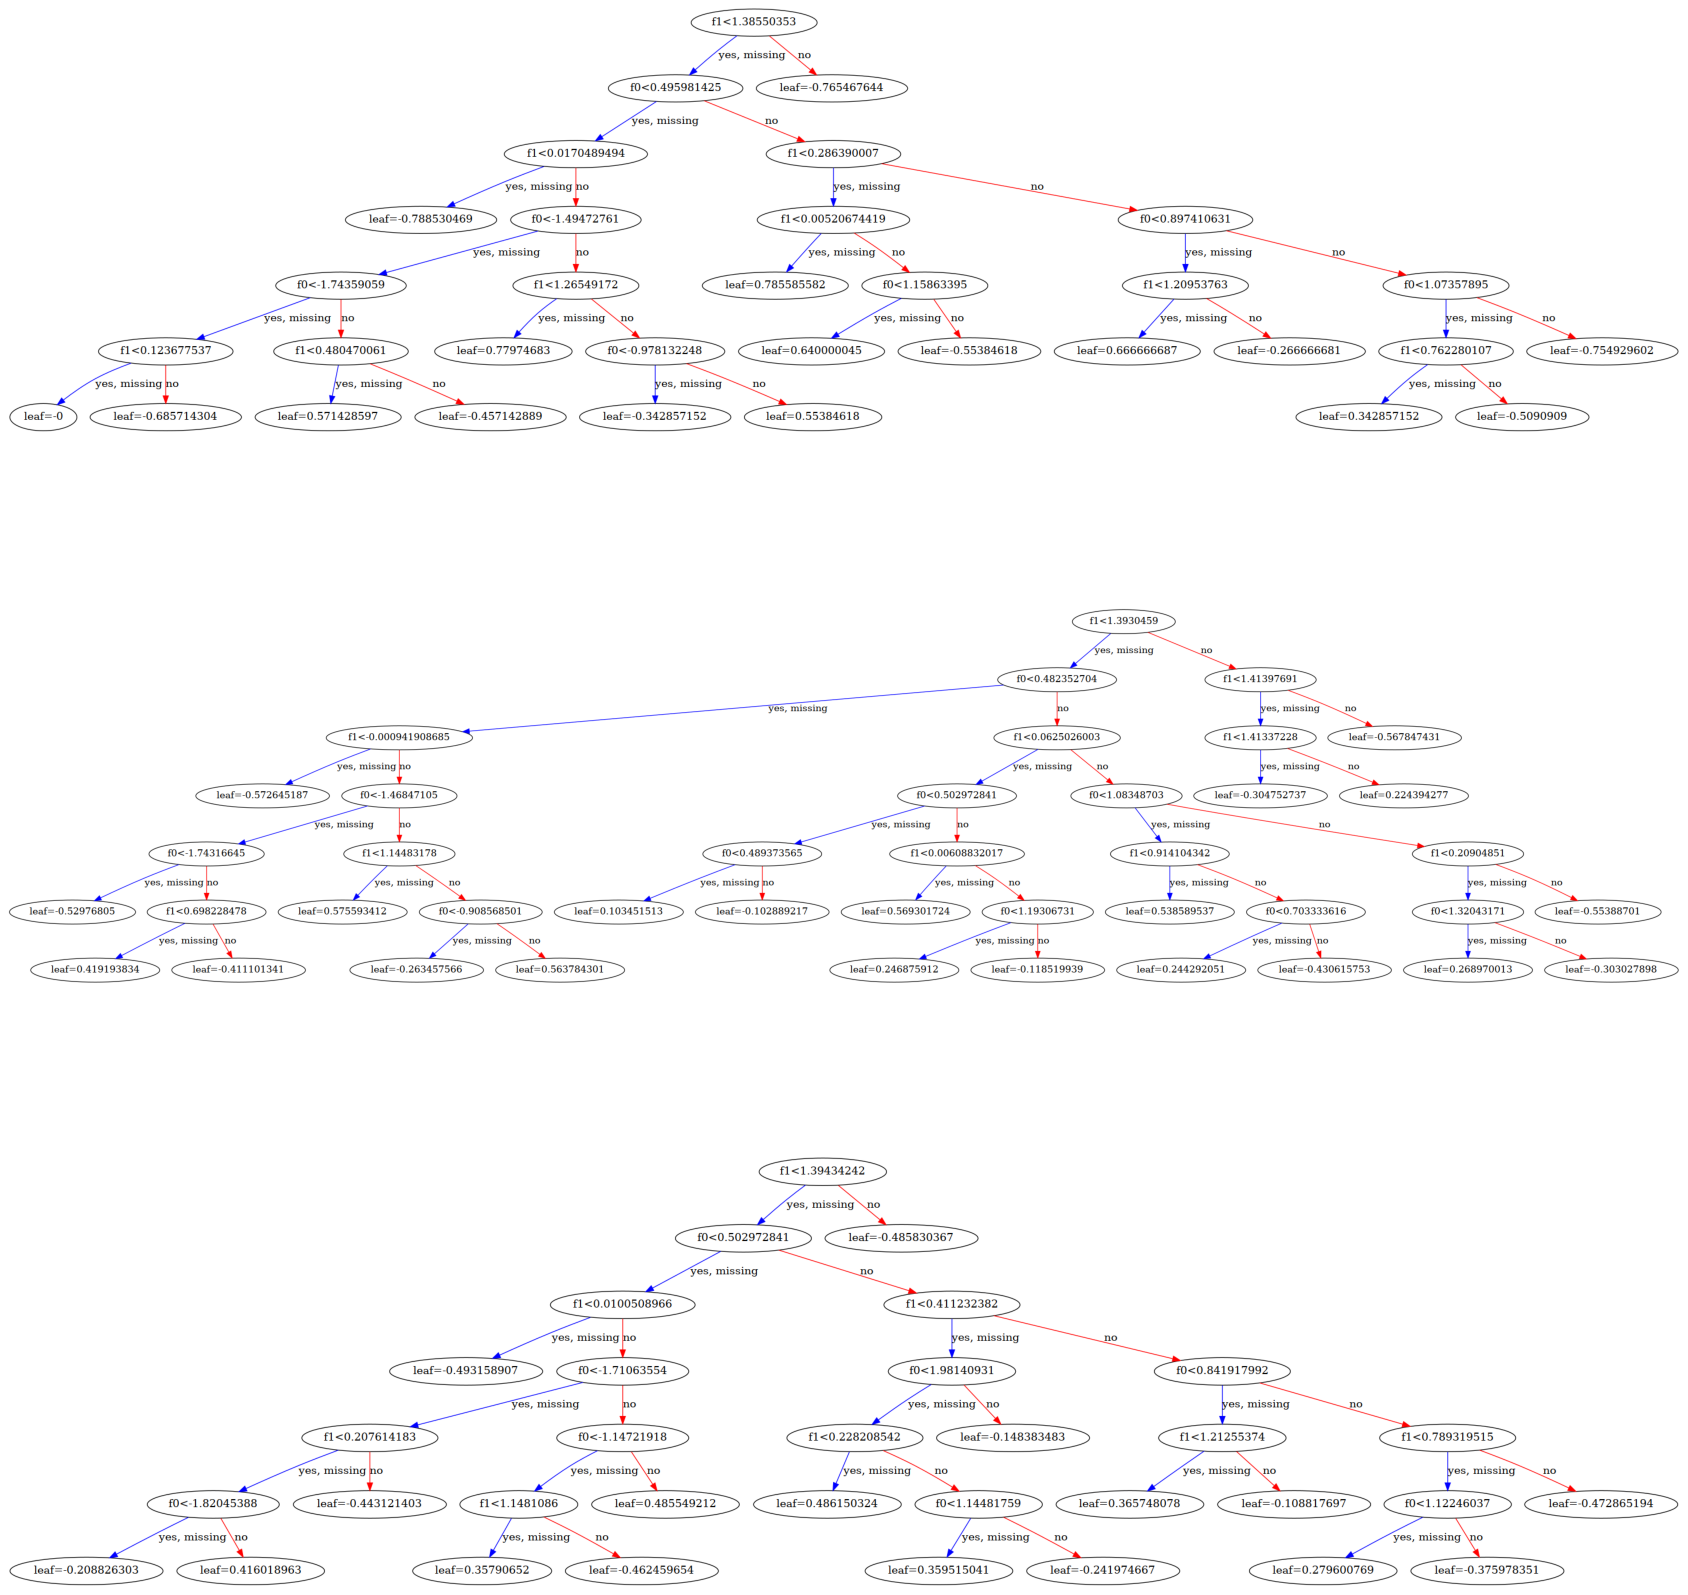

In [54]:
classify(XGBClassifier(seed=1,
                       objective='binary:logistic',
                       #objective="reg:squarederror",eval_metric="rmse",
                       reg_lambda=results.iloc[id]["param_reg_lambda"],
                       n_estimators=results.iloc[id]["param_n_estimators"],
                       min_split_loss=results.iloc[id]["param_min_split_loss"],
                       learning_rate=results.iloc[id]["param_learning_rate"],
                       max_depth=results.iloc[id]["param_max_depth"],
                       subsample=results.iloc[id]["param_subsample"],
                       min_child_weight=results.iloc[id]["param_min_child_weight"]),
                       show=True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1cb9264e-65a5-431d-a980-16667908489e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>